In [1]:
from scprint import scPrint
from scprint.tasks import GNInfer

from bengrn import BenGRN
import scanpy as sc

from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3, get_GT_db
from grnndata import utils as grnutils

import numpy as np

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [2]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 15728 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'leide

In [3]:
model = scPrint.load_from_checkpoint(
    '../../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', precpt_gene_emb=None)
NUM_GENES = 5000

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [4]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index

In [5]:
CELLTYPES = [
    'kidney distal convoluted tubule epithelial cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct principal cell',
    'mesangial cell',
    'blood vessel smooth muscle cell',
    'podocyte',
    'macrophage',
    'leukocyte',
    'kidney interstitial fibroblast',
    'endothelial cell'
]
celltype = 'podocyte'

# looking at omnipath to

In [ ]:
gt = get_GT_db(name="omnipath")

# Looking at GENIE3 cross cells and inverse network

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 34.39 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


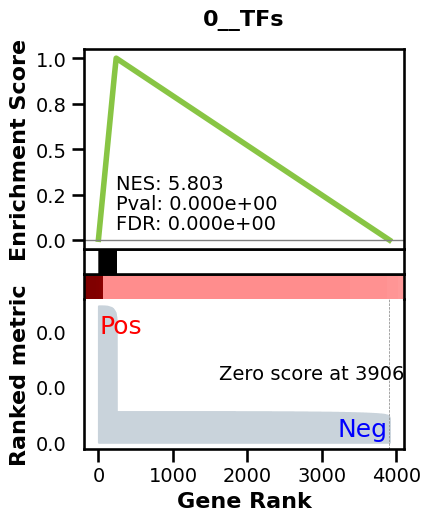

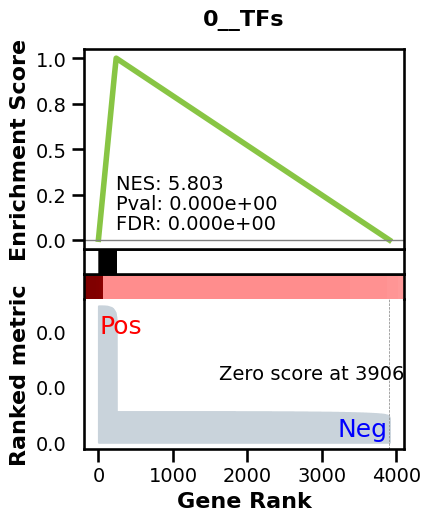

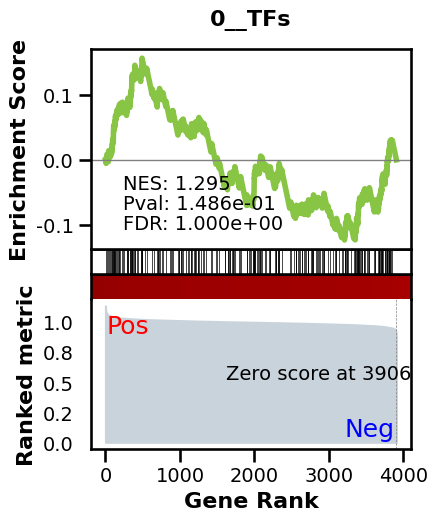

_________________________________________
TF specific enrichment
found some significant results for  2.7027027027027026 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2860 genes
intersection pct: 0.7320194522651651
precision:  0.008291468493576136 
recall:  0.4076179647527004 
random precision: 0.0015058568573783685


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:714: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 46%|████▋     | 46/99 [00:00<00:00, 64.96it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 63.64it/s]


Area Under Precision-Recall Curve (AUPRC):  0.006567968286300616
EPR: 6.021928115188223


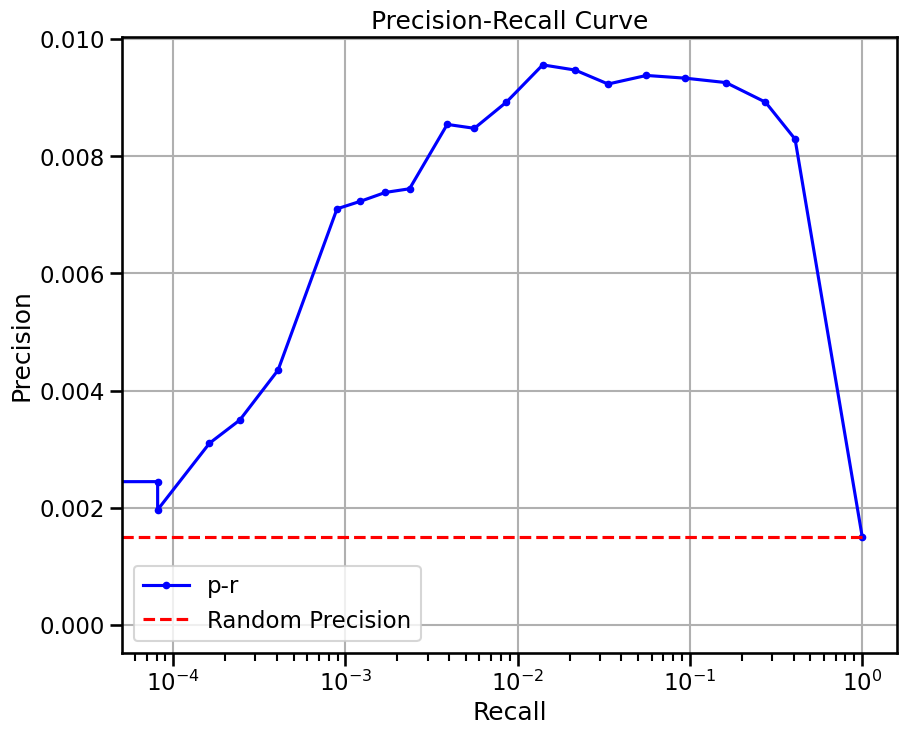

NameError: name 'metrics' is not defined

In [9]:
to_use = adata.uns["rank_genes_groups"]["names"][celltype][
    : NUM_GENES
].tolist()
subadata = adata[adata.obs.cell_type == celltype][:1024, adata.var.index.isin(
    model.genes) & adata.var.index.isin(to_use)]
genie_grn = compute_genie3(
    subadata, nthreads=32, regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var.index = make_index_unique(
    genie_grn.var['symbol'].astype(str))
BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 105.38 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


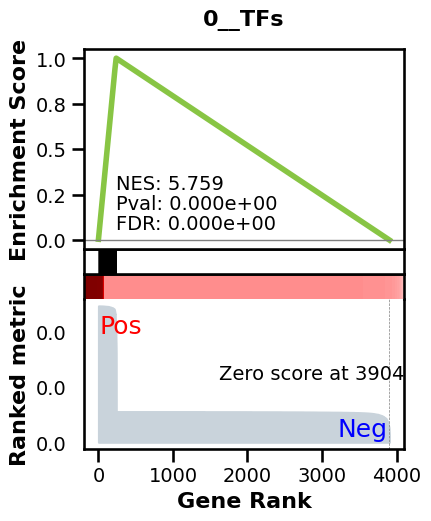

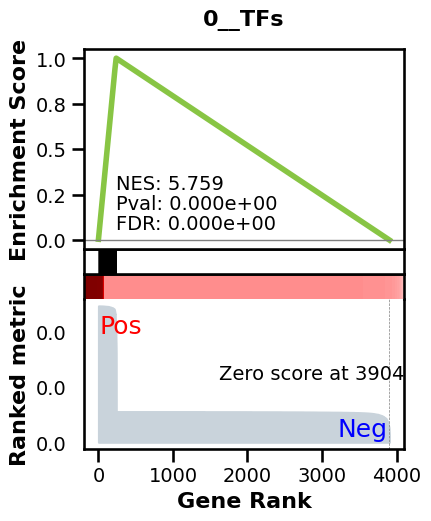

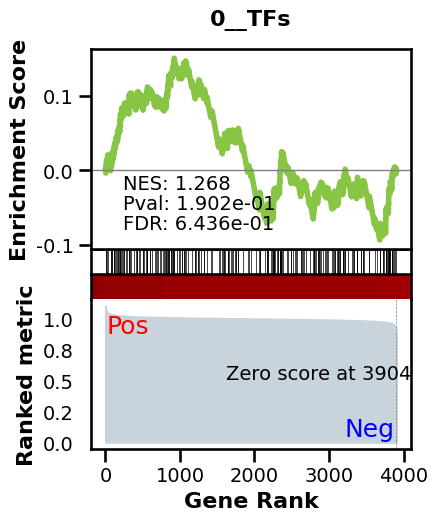

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2859 genes
intersection pct: 0.7321382842509603
precision:  0.008313635993153476 
recall:  0.4063414634146341 
random precision: 0.001505319652792515


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:714: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 47%|████▋     | 47/99 [00:00<00:00, 66.65it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 65.65it/s]


Area Under Precision-Recall Curve (AUPRC):  0.006393896139893461
EPR: 6.365775174615191


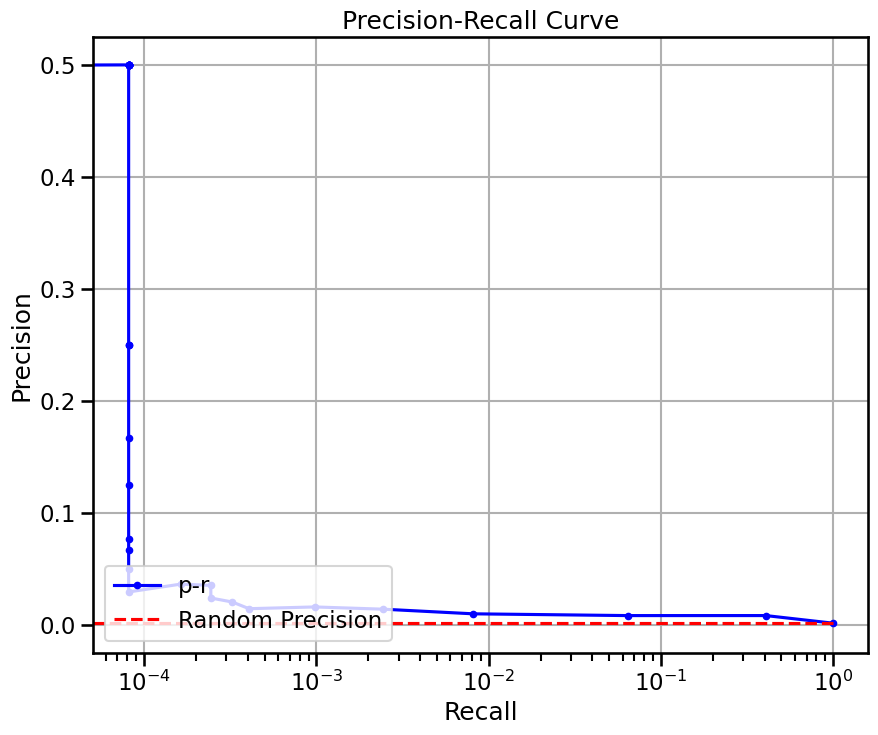

{'enriched_terms_Central': ['0__TFs',
  'celltype.gmt__Enteric neurons',
  'celltype.gmt__Embryonic stem cells',
  'celltype.gmt__Microfold cells',
  'celltype.gmt__Cap mesenchyme cells (Mesenchymal cells)'],
 'TF_enr': True,
 'significant_enriched_TFtargets': 0.0,
 'precision': 0.008313635993153476,
 'recall': 0.4063414634146341,
 'rand_precision': 0.001505319652792515,
 'auprc': 0.006393896139893461,
 'epr': 6.365775174615191}

In [11]:
to_use = adata.uns["rank_genes_groups"]["names"][celltype][
    : NUM_GENES
].tolist()
subadata = adata[adata.obs.cell_type.isin(CELLTYPES[:5])][:, adata.var.index.isin(
    model.genes) & adata.var.index.isin(to_use)]
genie_grn = compute_genie3(
    subadata, nthreads=32, regulators=adata.var[adata.var.isTF].index.tolist())
genie_grn.var.index = make_index_unique(
    genie_grn.var['symbol'].astype(str))
BenGRN(genie_grn, do_auc=True, doplot=True).scprint_benchmark()

View of AnnData object with n_obs × n_vars = 1024 × 3863
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


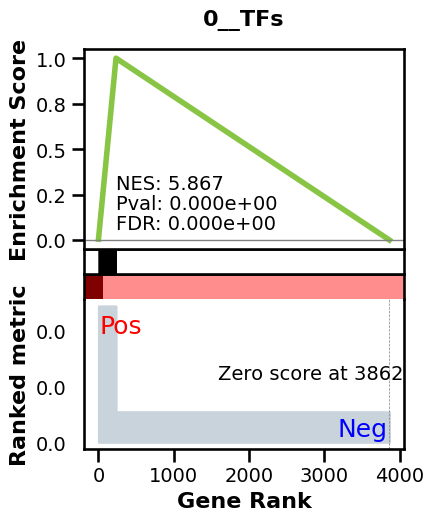

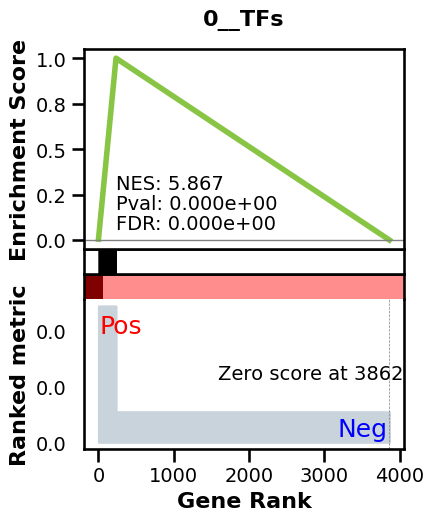

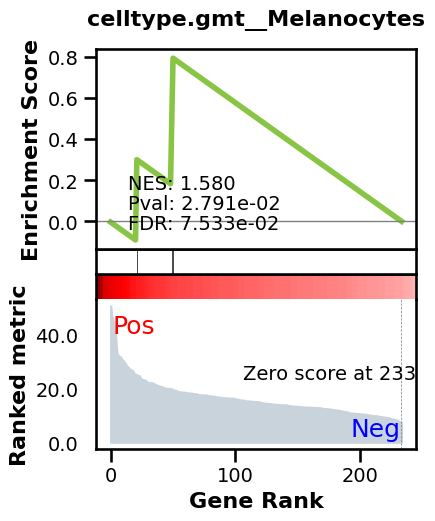

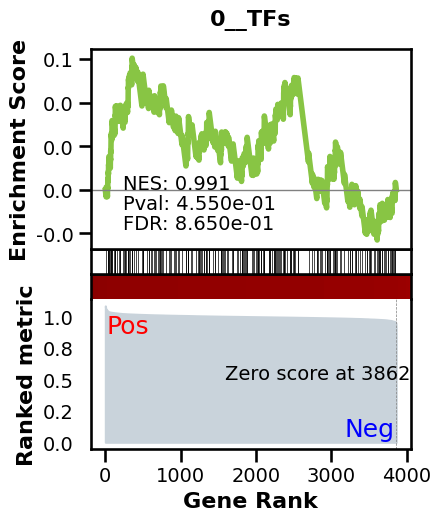

_________________________________________
TF specific enrichment


2024-05-22 14:48:18,951:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 14:48:18,963:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 14:48:19,206:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2767 genes
intersection pct: 0.7162826818534818
precision:  0.0058326802615713 
recall:  0.3539369640271745 
random precision: 0.0011731853648555529


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 48%|████▊     | 48/99 [00:00<00:00, 68.05it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 66.46it/s]


Area Under Precision-Recall Curve (AUPRC):  0.004574489307575469
EPR: 6.1486821161659835


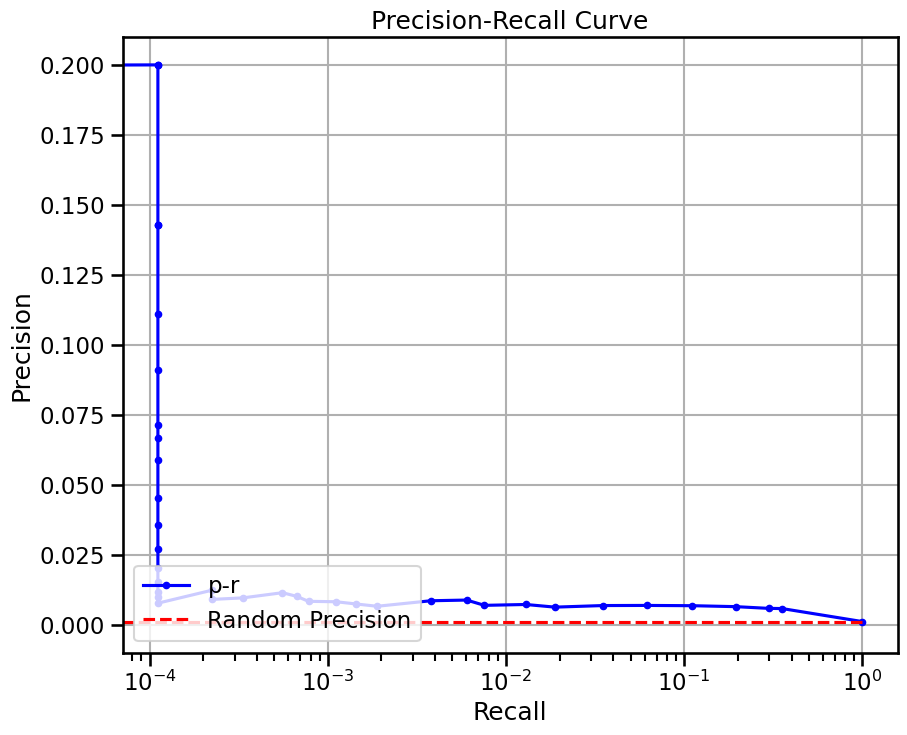

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 199.30 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


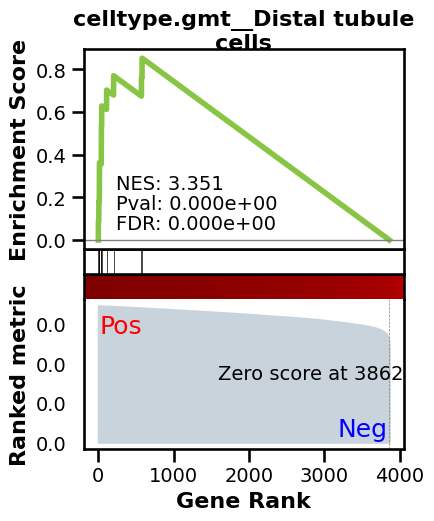

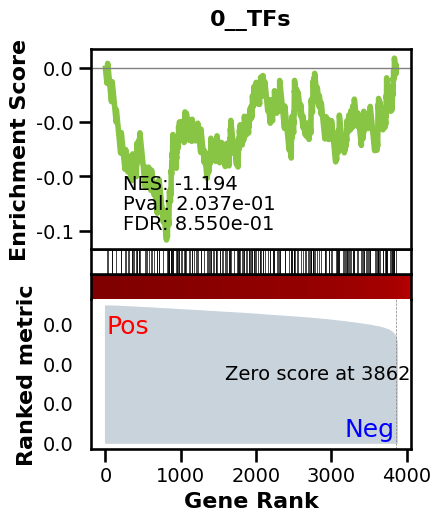

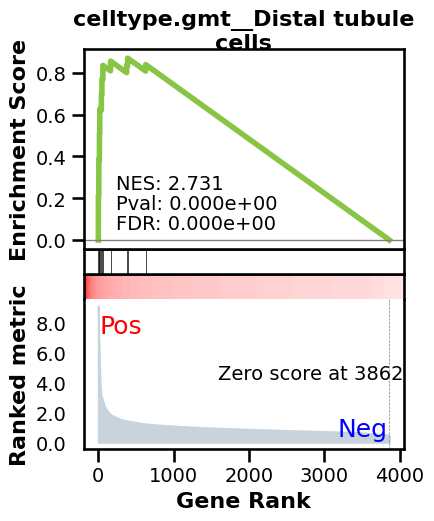

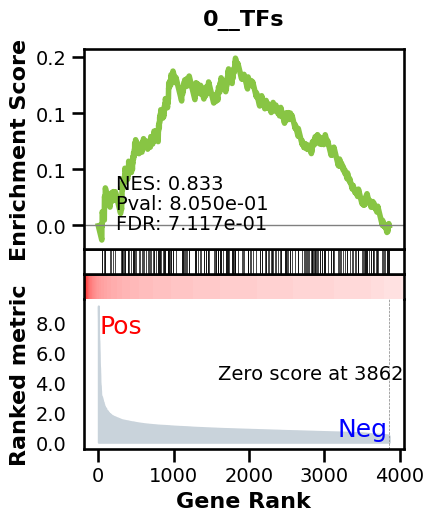

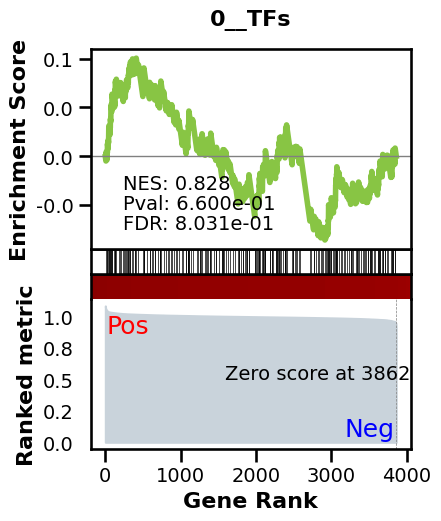

_________________________________________
TF specific enrichment


2024-05-22 14:52:30,930:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 14:52:30,933:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 14:52:31,139:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  3.4482758620689653 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2767 genes
intersection pct: 0.7162826818534818
precision:  0.001201016147693546 
recall:  0.8296024056130973 
random precision: 0.0011731853648555529


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 42%|████▏     | 42/99 [00:00<00:00, 69.48it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 68.64it/s]


Area Under Precision-Recall Curve (AUPRC):  0.001180784053858292
EPR: 0.6639892222278098


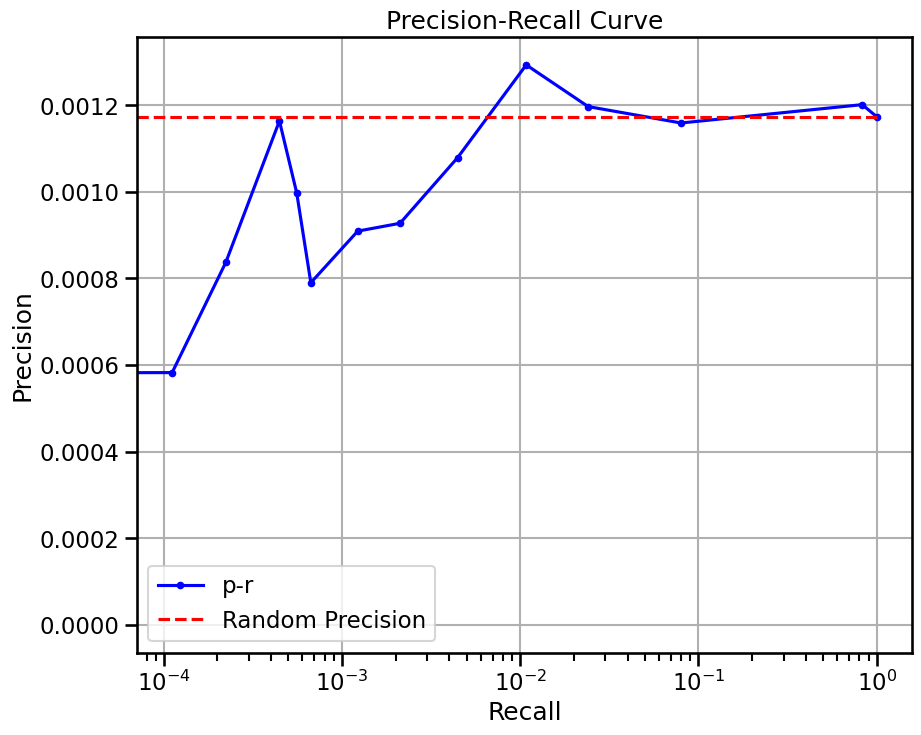

View of AnnData object with n_obs × n_vars = 388 × 3822
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', '

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


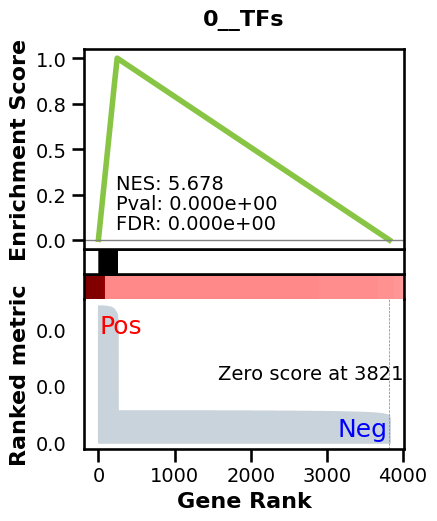

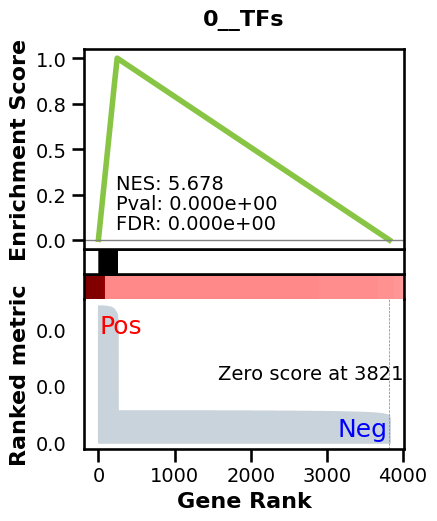

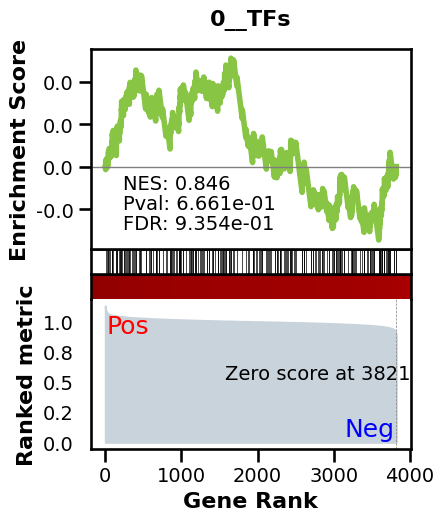

_________________________________________
TF specific enrichment


2024-05-22 14:53:39,815:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 14:53:39,817:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 14:53:40,040:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  3.0303030303030303 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2710 genes
intersection pct: 0.7090528519099948
precision:  0.007098441582220094 
recall:  0.45974914481185863 
random precision: 0.0011945966635746091


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 46%|████▋     | 46/99 [00:00<00:00, 75.79it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 75.67it/s]


Area Under Precision-Recall Curve (AUPRC):  0.005327511307543376
EPR: 4.232181741646476


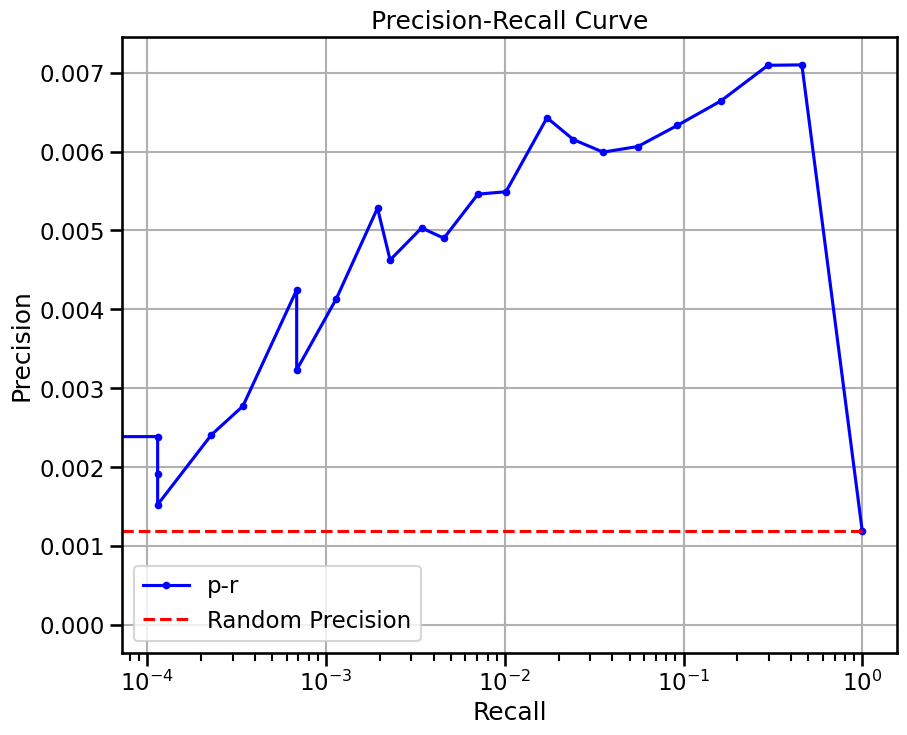

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 55.04 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


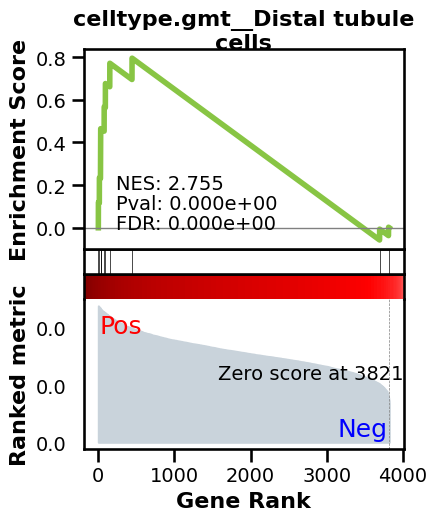

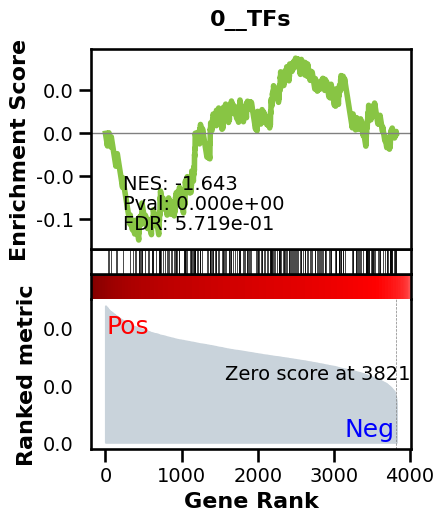

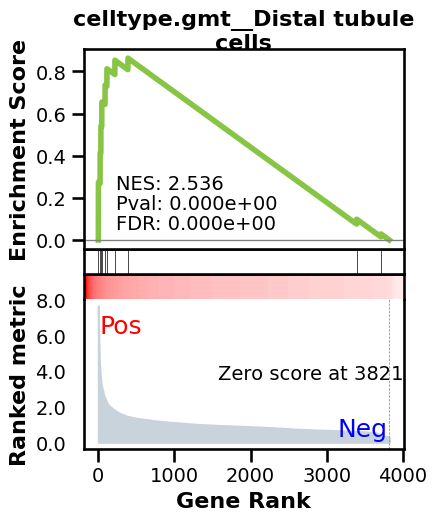

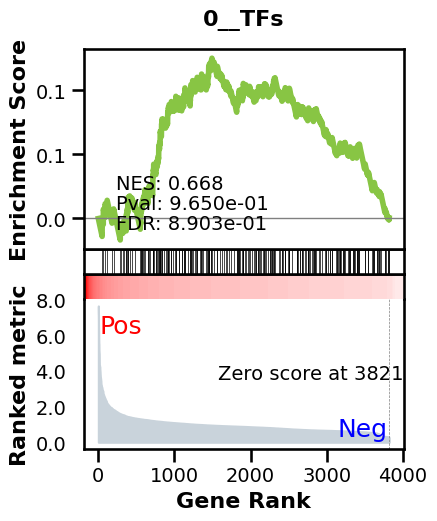

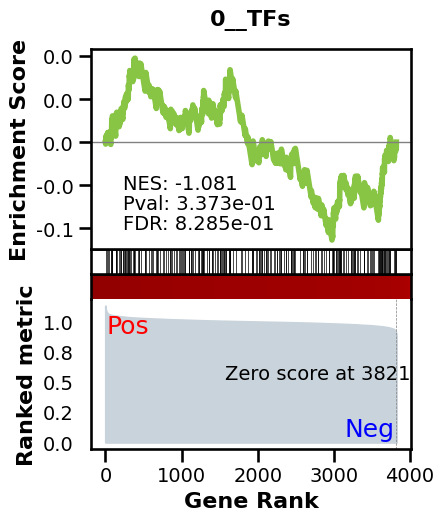

_________________________________________
TF specific enrichment


2024-05-22 14:55:18,704:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 14:55:18,706:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 14:55:18,906:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  3.0303030303030303 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2710 genes
intersection pct: 0.7090528519099948
precision:  0.0012290977960821472 
recall:  0.47388825541619156 
random precision: 0.0011945966635746091


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: invalid value encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
 47%|████▋     | 47/99 [00:00<00:00, 76.32it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 75.58it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0011794644118902672
EPR: 0.5721189189166669


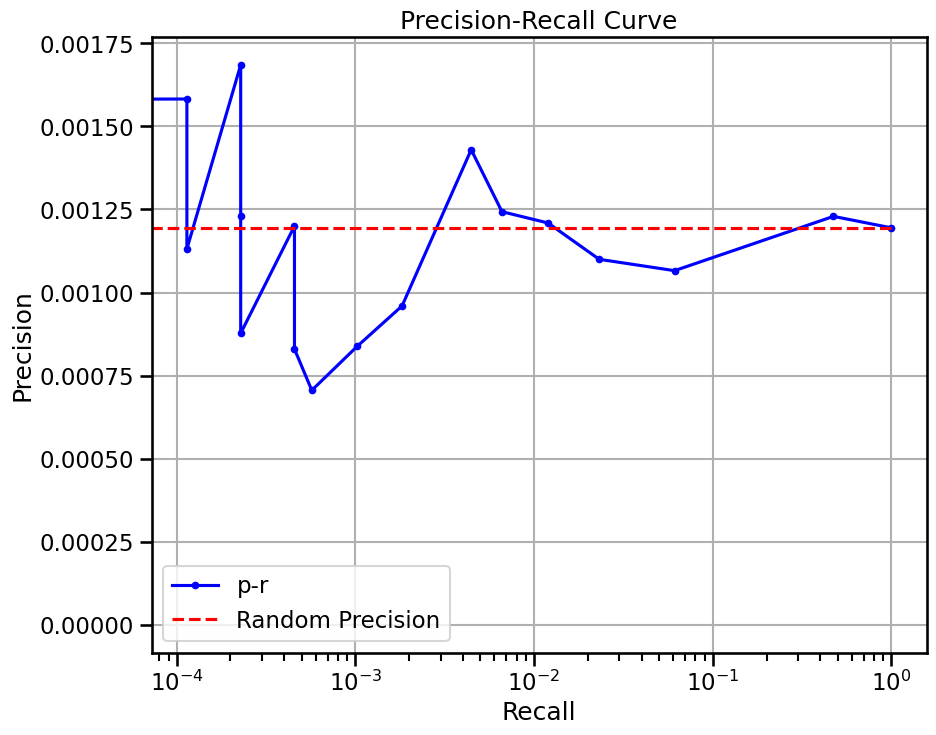

View of AnnData object with n_obs × n_vars = 455 × 3892
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', '

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


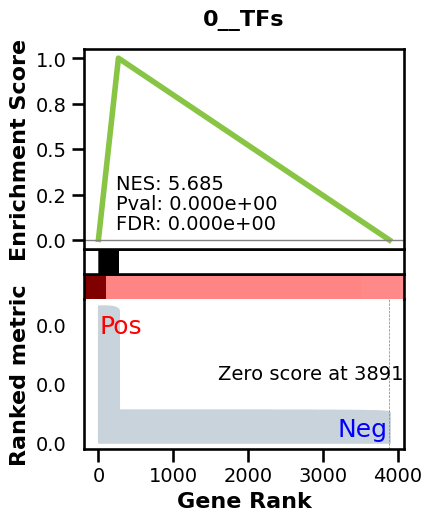

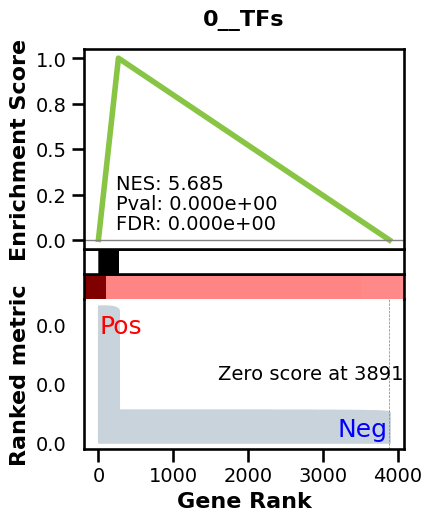

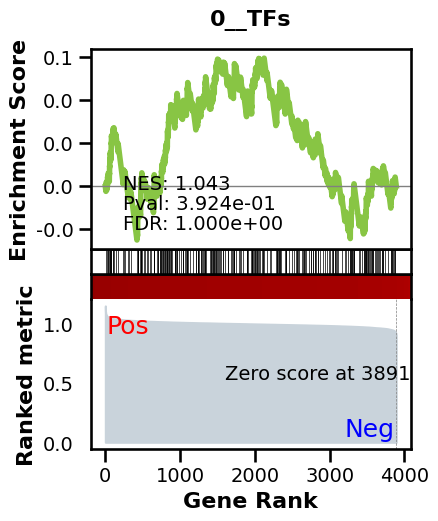

_________________________________________
TF specific enrichment


2024-05-22 14:56:34,093:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 14:56:34,095:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 14:56:34,290:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  6.451612903225806 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2829 genes
intersection pct: 0.7268756423432683
precision:  0.008600188795701267 
recall:  0.4603611628471941 
random precision: 0.0015435455074063686


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 46%|████▋     | 46/99 [00:00<00:00, 70.29it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 69.96it/s]


Area Under Precision-Recall Curve (AUPRC):  0.008026706264874535
EPR: 11.646937850396412


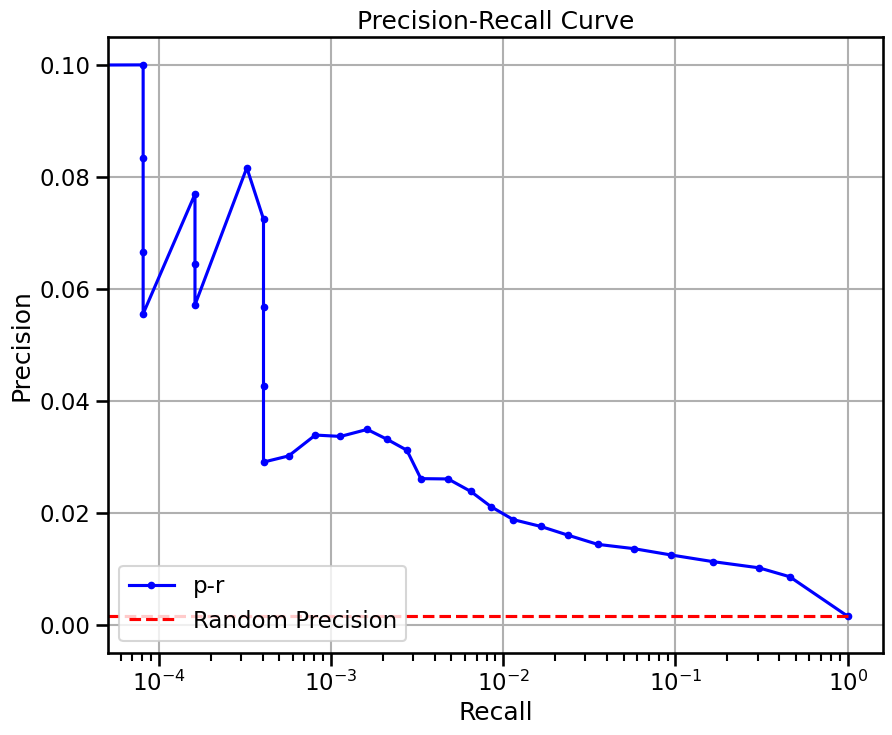

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 74.90 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


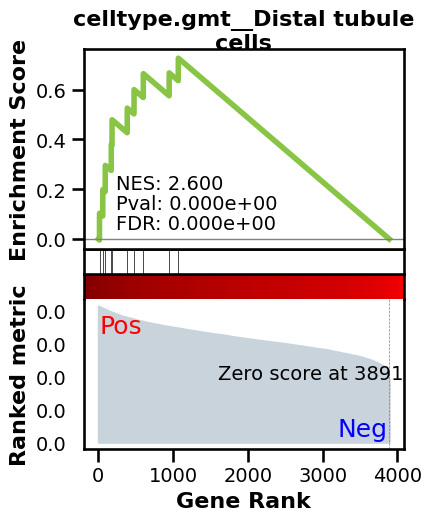

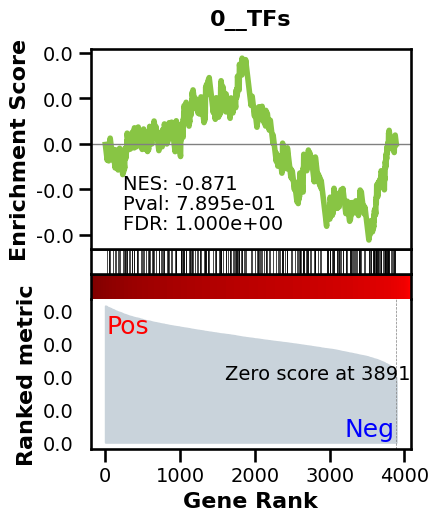

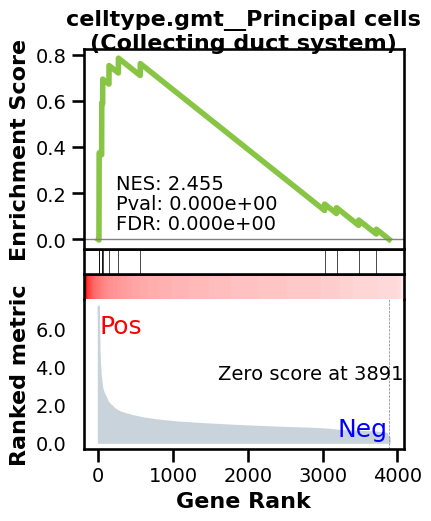

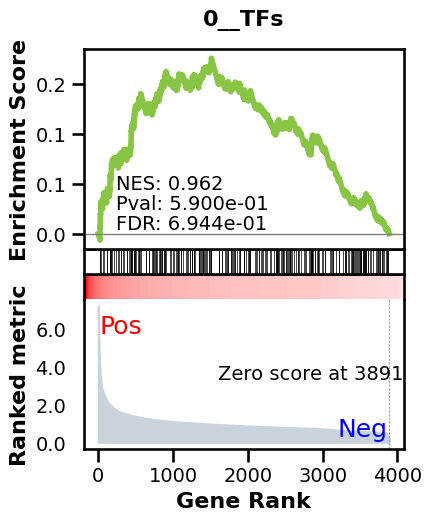

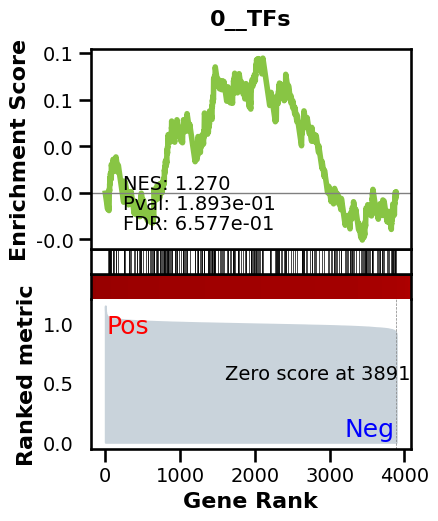

_________________________________________
TF specific enrichment


2024-05-22 14:58:44,761:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 14:58:44,763:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 14:58:44,972:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2829 genes
intersection pct: 0.7268756423432683
precision:  0.0016712512087457506 
recall:  0.6124382541096445 
random precision: 0.0015435455074063686


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: invalid value encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
 48%|████▊     | 48/99 [00:00<00:00, 63.58it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 62.62it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0016397720920919578
EPR: 1.3655620504299166


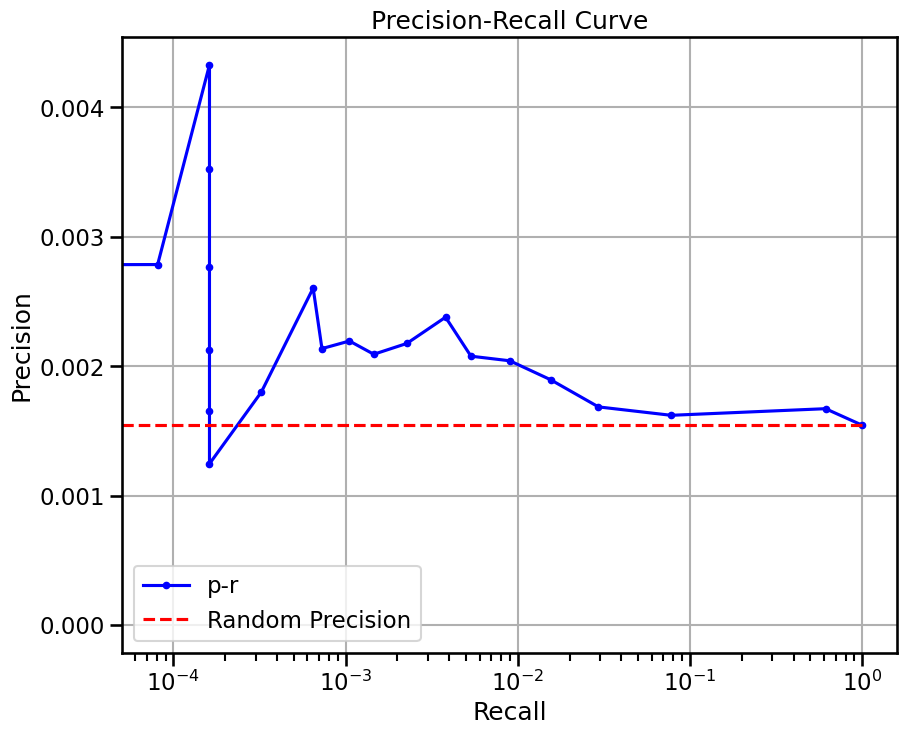

View of AnnData object with n_obs × n_vars = 10 × 3698
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'l

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


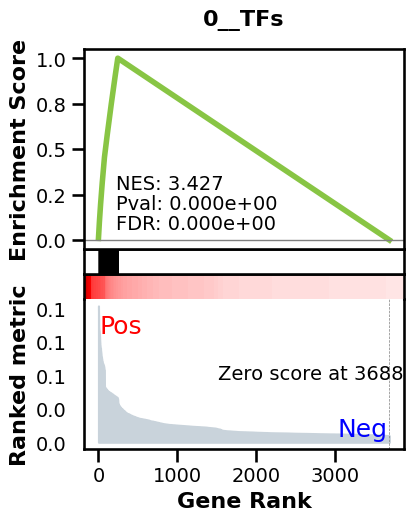

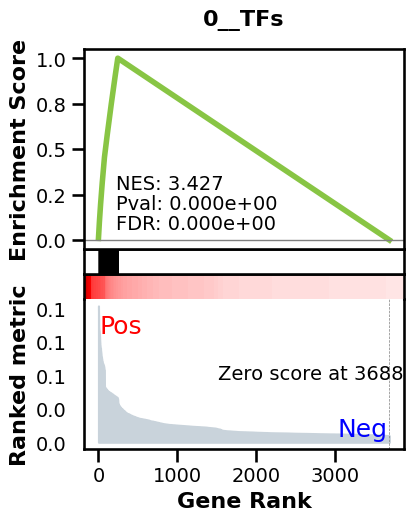

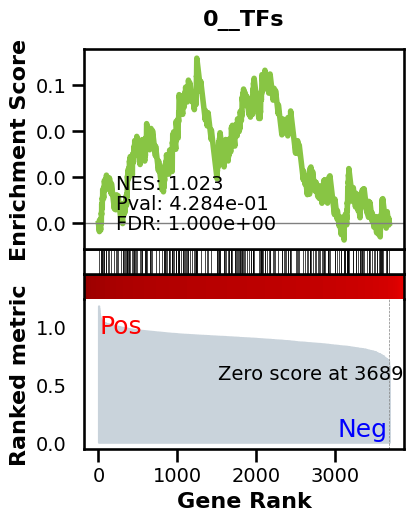

_________________________________________
TF specific enrichment


2024-05-22 14:59:44,135:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 14:59:44,137:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 14:59:44,350:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  2.380952380952381 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2670 genes
intersection pct: 0.7235772357723578
precision:  0.011130476676302216 
recall:  0.1803052909445656 
random precision: 0.0012226661221992553


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: invalid value encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
 49%|████▉     | 49/99 [00:00<00:01, 47.48it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:02<00:00, 47.45it/s]


Area Under Precision-Recall Curve (AUPRC):  0.006869549168649765
EPR: 6.5647823191227435


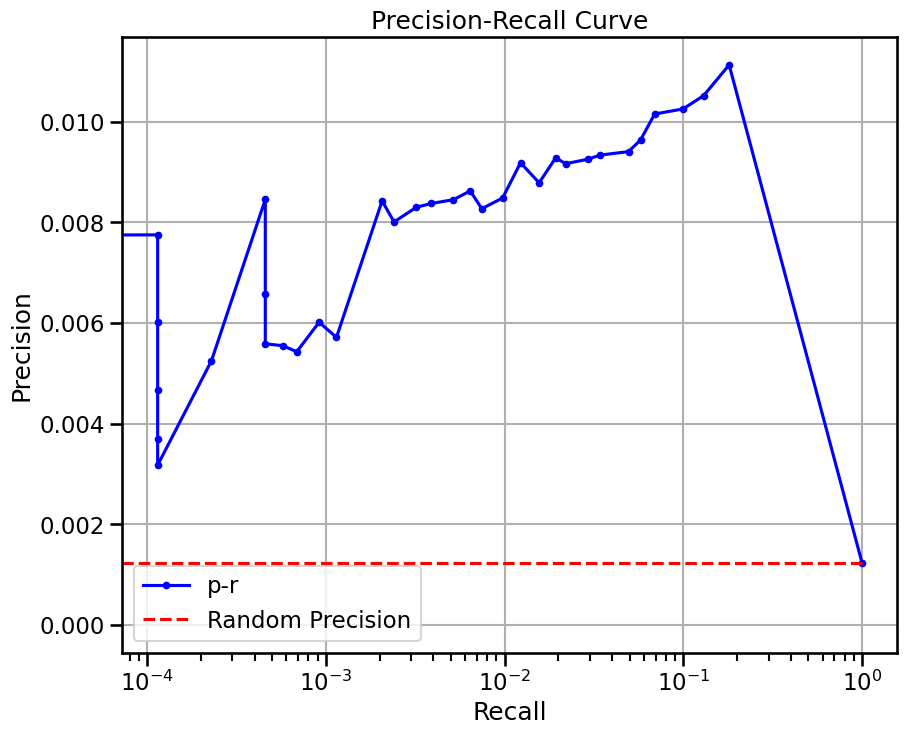

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 22.09 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


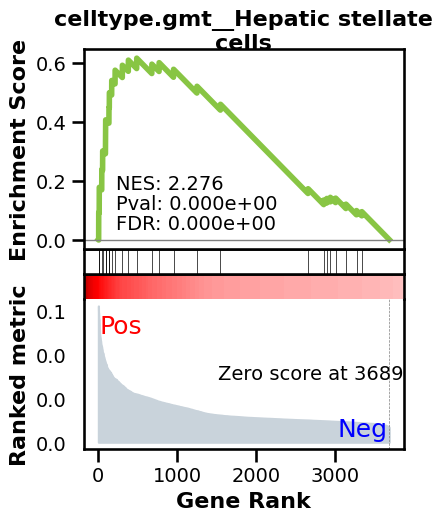

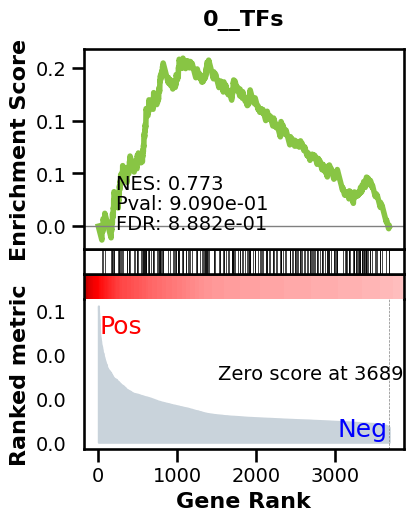

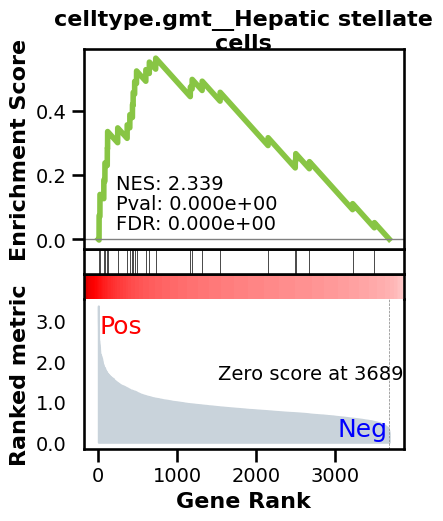

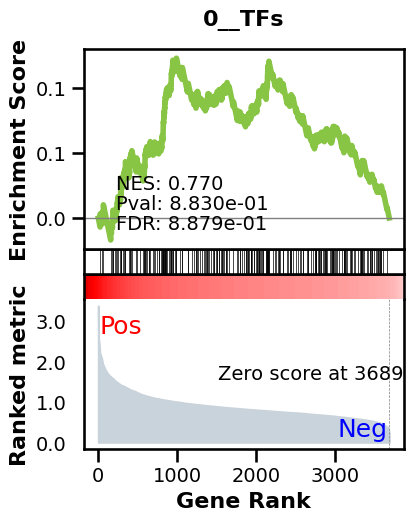

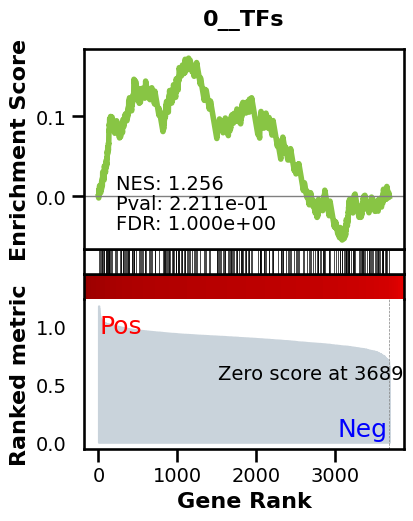

_________________________________________
TF specific enrichment


2024-05-22 15:00:37,935:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:00:37,936:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:00:38,129:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  4.761904761904762 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2670 genes
intersection pct: 0.7235772357723578
precision:  0.0015768102196271378 
recall:  0.030529094456559165 
random precision: 0.0012226661221992553


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 46%|████▋     | 46/99 [00:00<00:00, 71.10it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 70.39it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0014044961419215924
EPR: 1.59811282974164


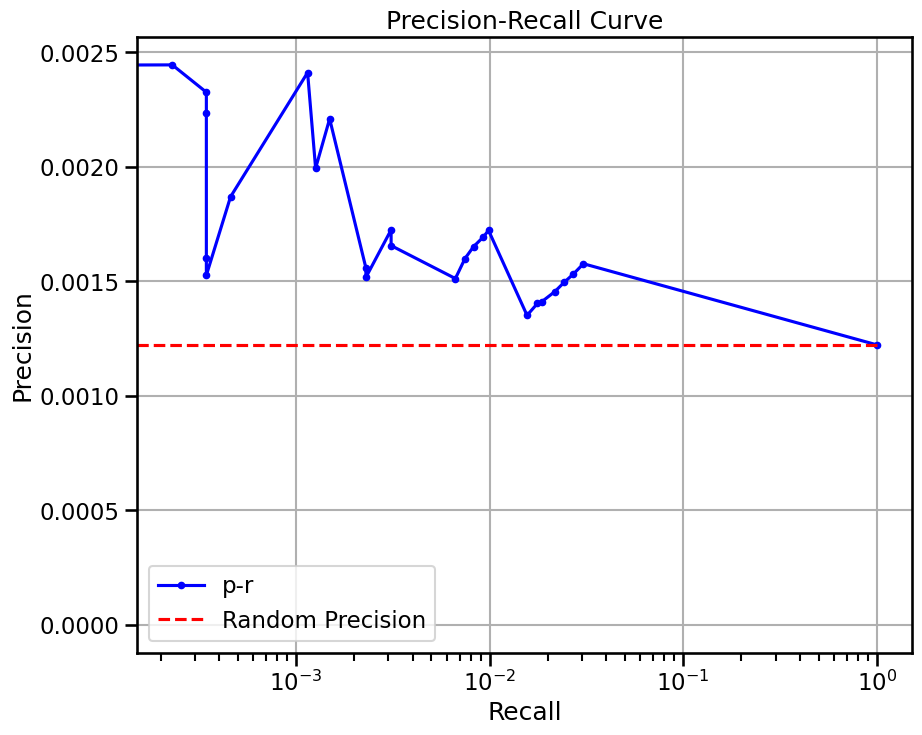

View of AnnData object with n_obs × n_vars = 462 × 3686
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', '

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


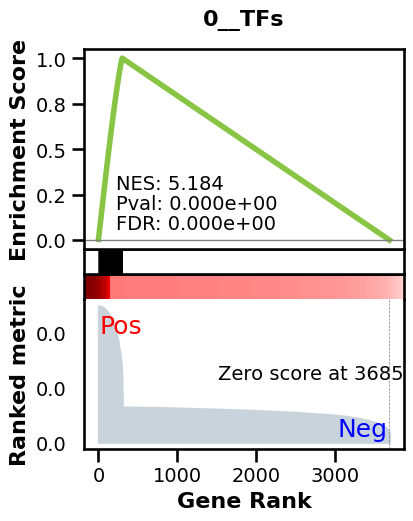

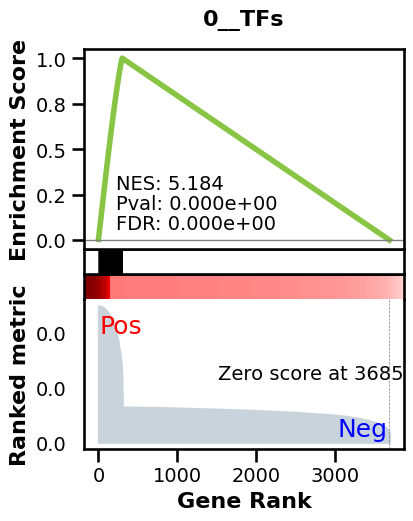

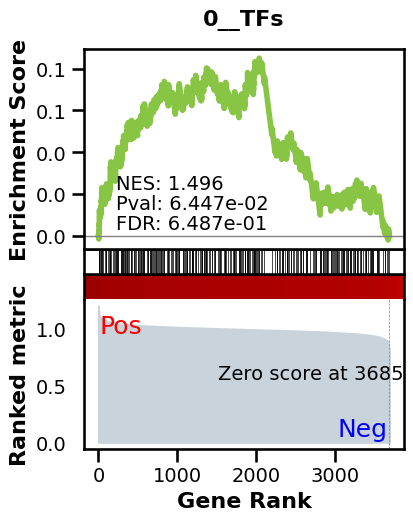

_________________________________________
TF specific enrichment


2024-05-22 15:01:49,364:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:01:49,366:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:01:49,596:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  2.0833333333333335 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2707 genes
intersection pct: 0.7344004340748779
precision:  0.008082338103783044 
recall:  0.4154544690153872 
random precision: 0.0016235862731398246


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: invalid value encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
 46%|████▋     | 46/99 [00:00<00:00, 70.67it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 69.69it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0074339085110626075
EPR: 8.758895970383257


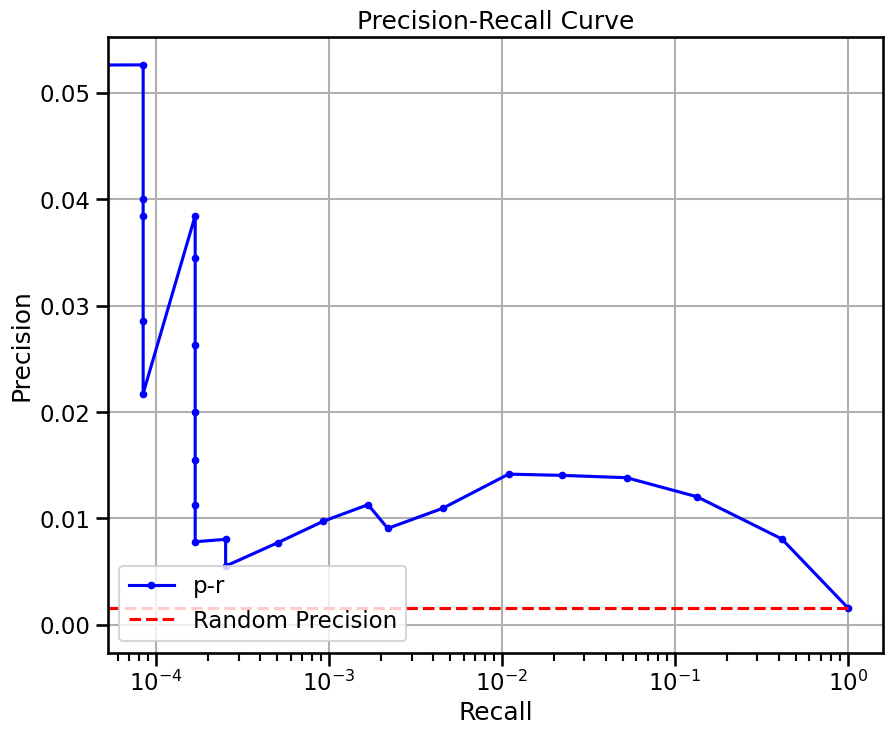

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 50.24 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


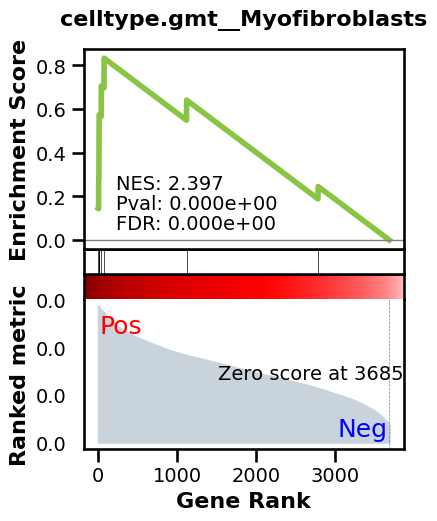

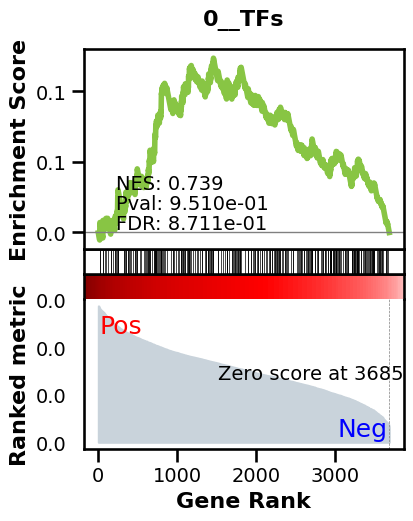

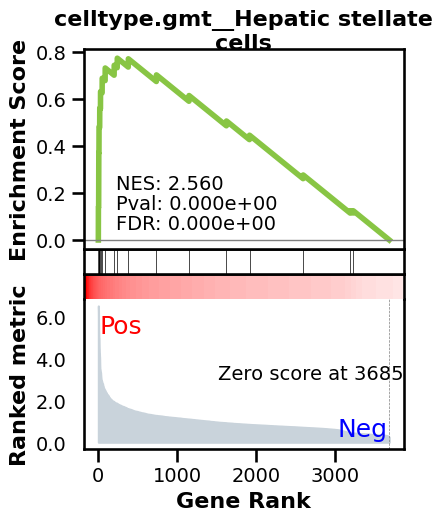

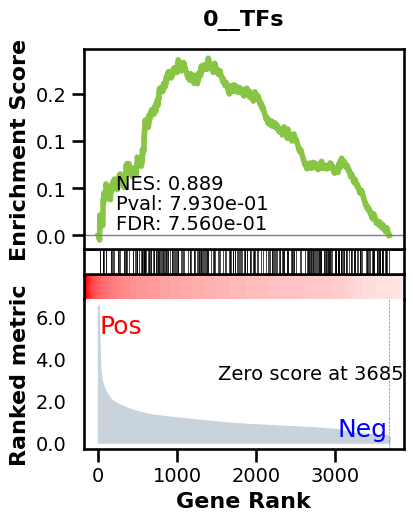

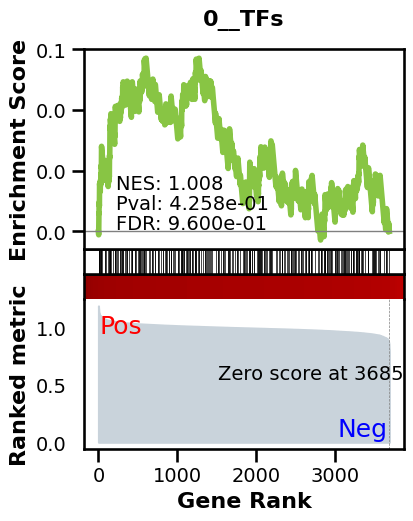

_________________________________________
TF specific enrichment


2024-05-22 15:03:22,477:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:03:22,479:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:03:22,675:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  2.0833333333333335 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2707 genes
intersection pct: 0.7344004340748779
precision:  0.002195240838041986 
recall:  0.46691331035062644 
random precision: 0.0016235862731398246


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: invalid value encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
 43%|████▎     | 43/99 [00:00<00:00, 69.34it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 68.43it/s]


Area Under Precision-Recall Curve (AUPRC):  0.001987455418529454
EPR: 1.6607826310838938


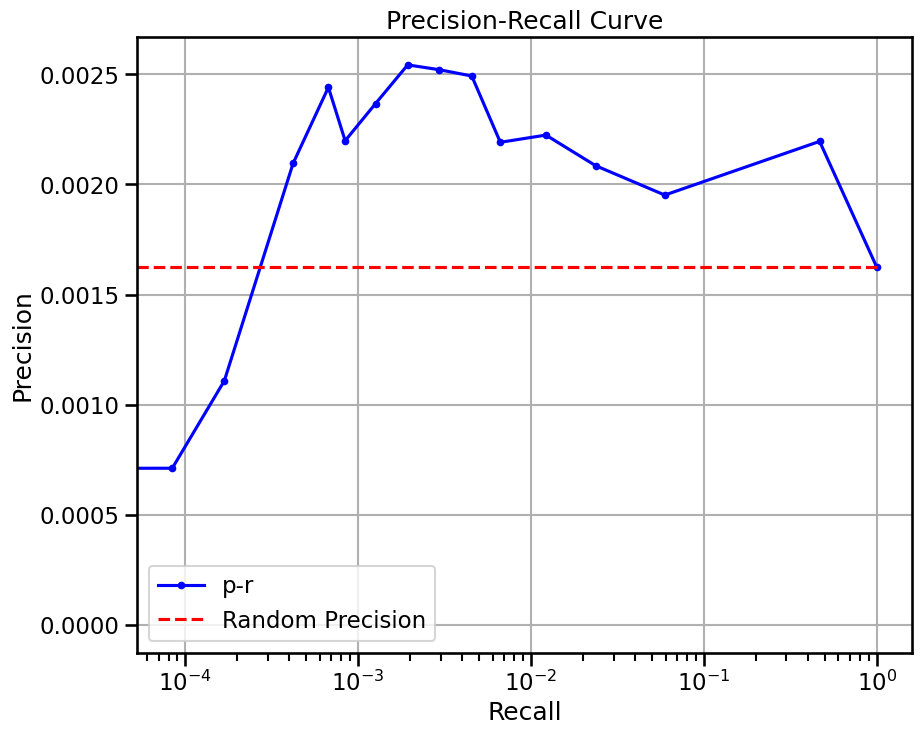

View of AnnData object with n_obs × n_vars = 518 × 3907
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', '

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


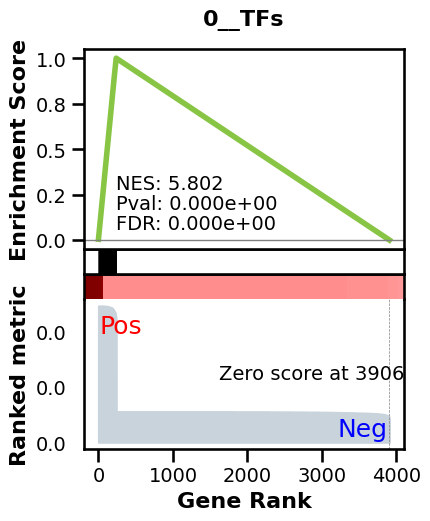

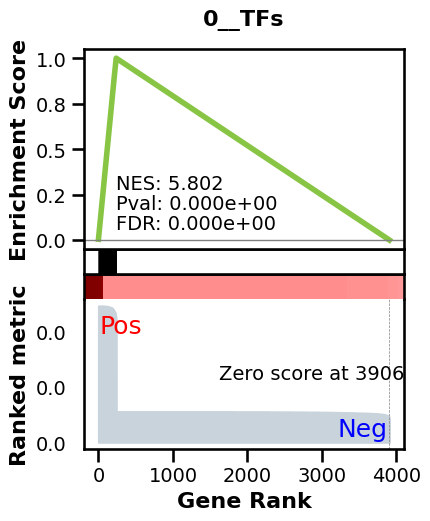

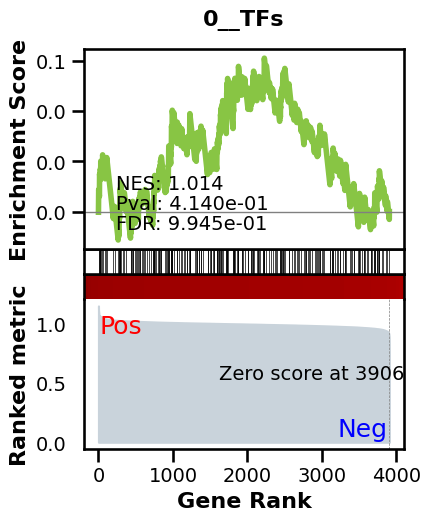

_________________________________________
TF specific enrichment


2024-05-22 15:04:42,977:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:04:42,980:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:04:43,174:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  5.405405405405405 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2860 genes
intersection pct: 0.7320194522651651
precision:  0.008299070609854443 
recall:  0.40786160968082513 
random precision: 0.0015058568573783685


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 48%|████▊     | 48/99 [00:00<00:00, 63.47it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 62.75it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0065982889653285305
EPR: 6.412501912030257


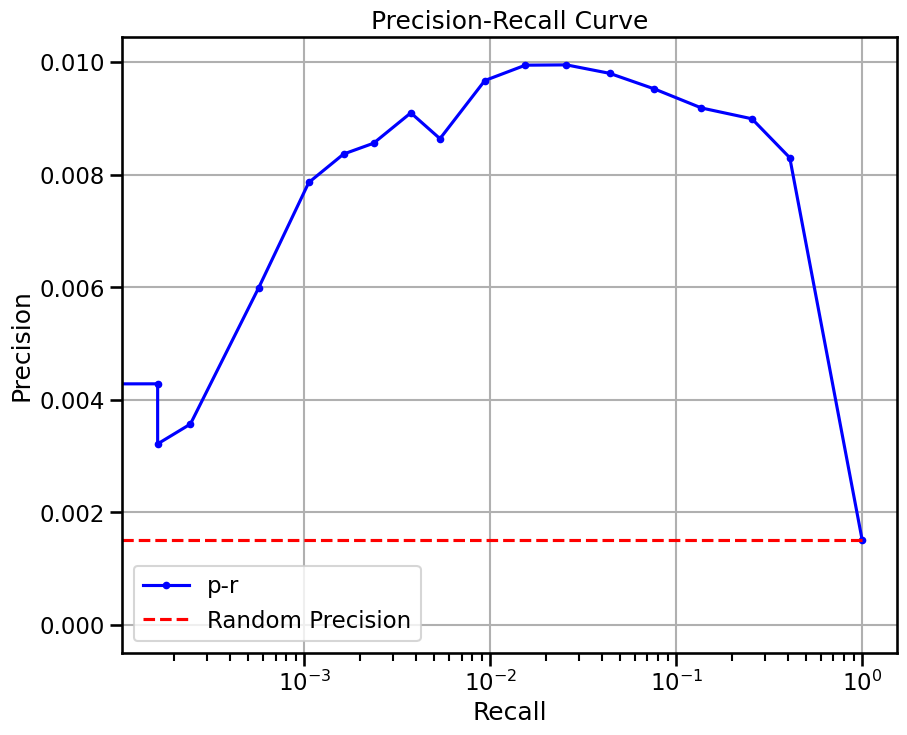

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 79.13 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


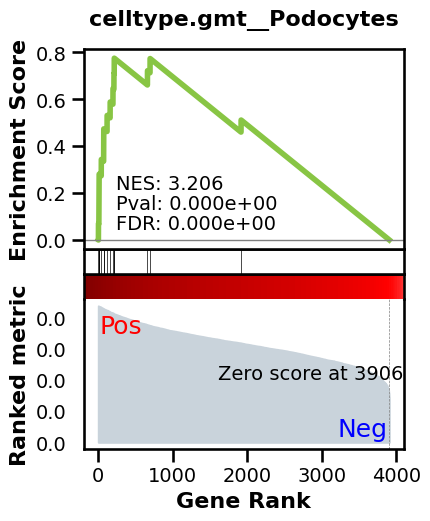

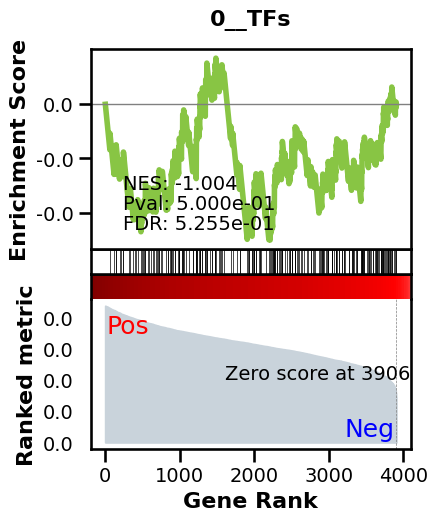

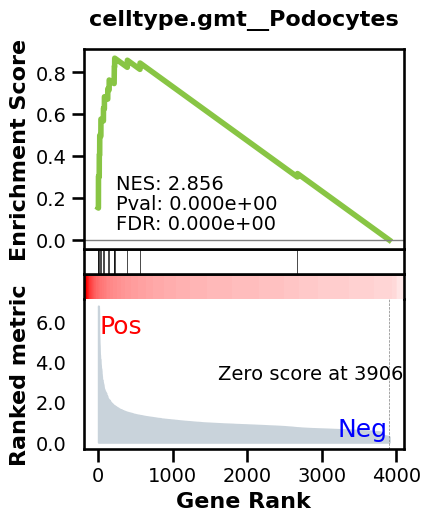

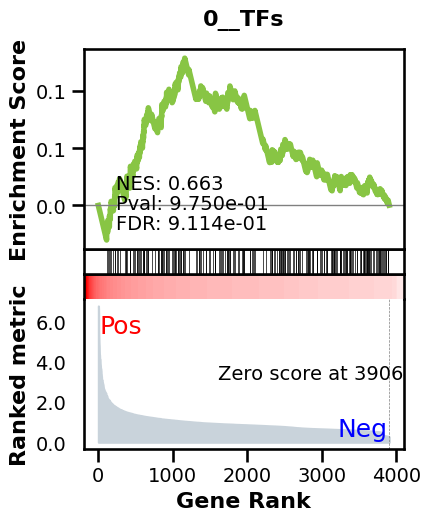

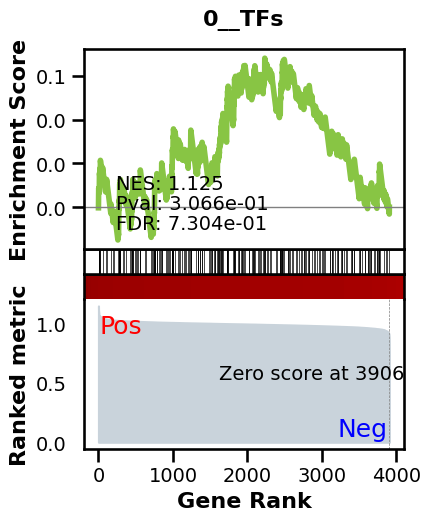

_________________________________________
TF specific enrichment


2024-05-22 15:06:54,533:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:06:54,535:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:06:54,732:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  2.7027027027027026 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2860 genes
intersection pct: 0.7320194522651651
precision:  0.0016268359779406493 
recall:  0.5621700641598311 
random precision: 0.0015058568573783685


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 47%|████▋     | 47/99 [00:00<00:00, 63.72it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 61.69it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0015478871503586907
EPR: 0.808524761611291


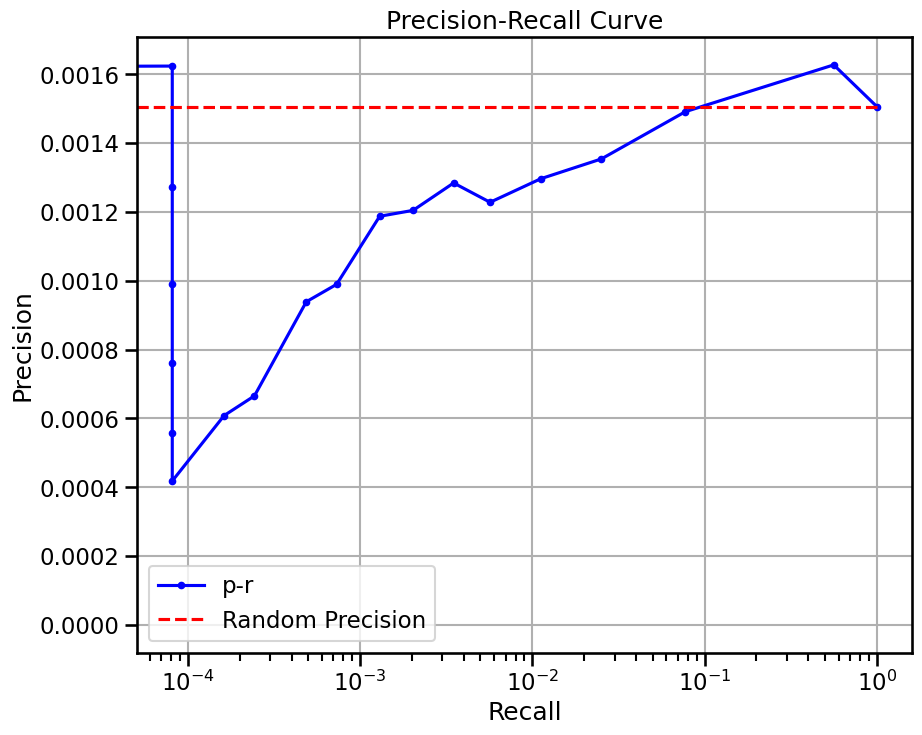

View of AnnData object with n_obs × n_vars = 88 × 3517
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'l

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


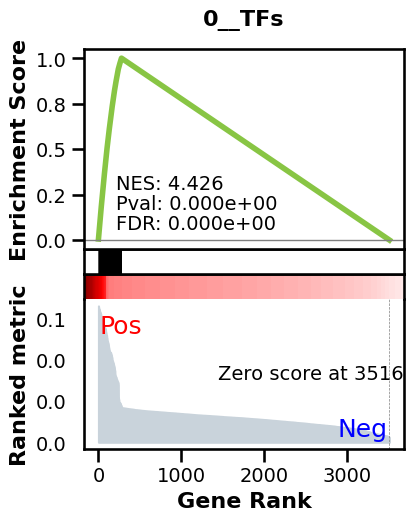

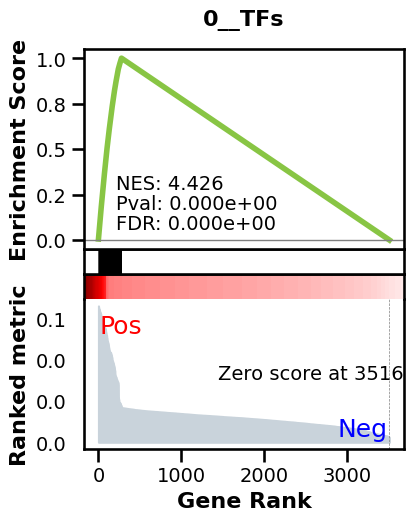

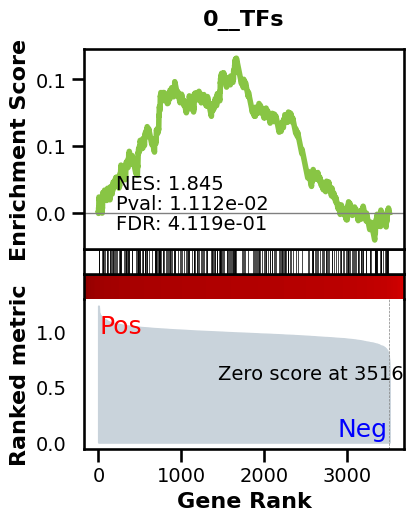

_________________________________________
TF specific enrichment


2024-05-22 15:07:53,402:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:07:53,404:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:07:53,638:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2542 genes
intersection pct: 0.7227750924083025
precision:  0.010418280402788535 
recall:  0.3659863945578231 
random precision: 0.0015930711159950841


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: invalid value encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
 43%|████▎     | 43/99 [00:00<00:00, 79.77it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 79.38it/s]


Area Under Precision-Recall Curve (AUPRC):  0.007985468855584951
EPR: 7.0884719039248845


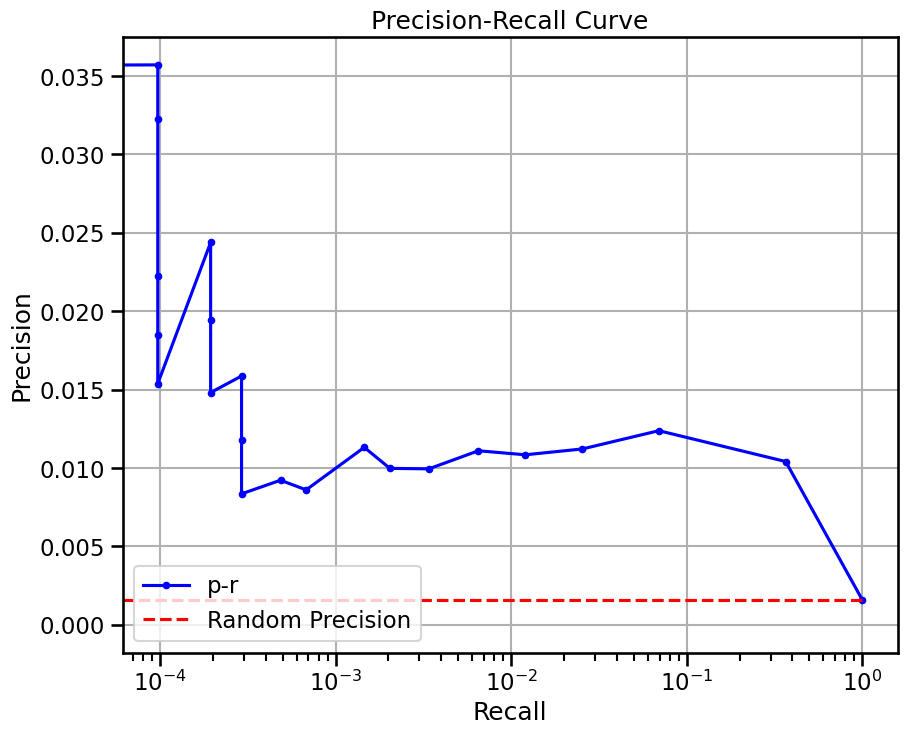

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 23.94 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


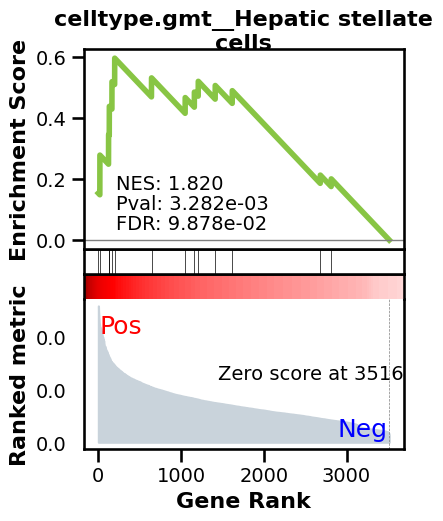

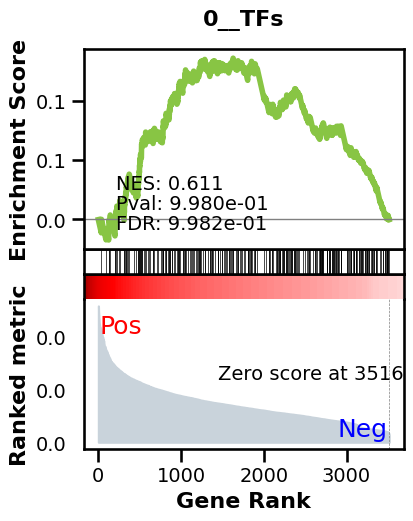

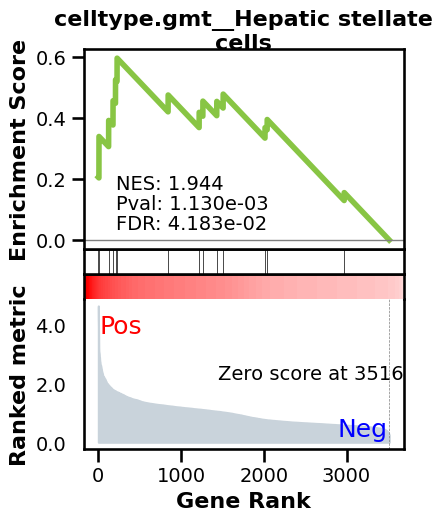

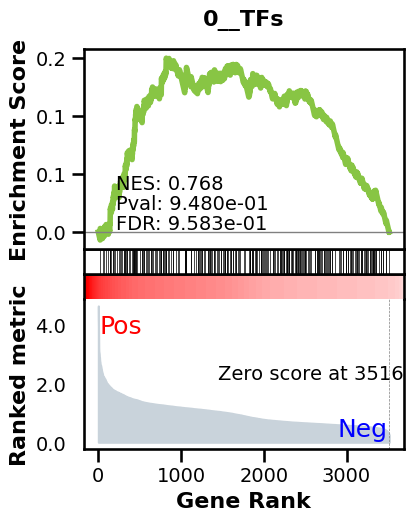

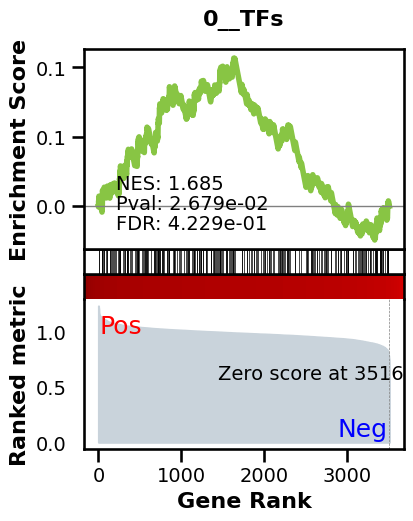

_________________________________________
TF specific enrichment


2024-05-22 15:08:47,686:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:08:47,688:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:08:47,881:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2542 genes
intersection pct: 0.7227750924083025
precision:  0.0020268118665316415 
recall:  0.13731778425655977 
random precision: 0.0015930711159950841


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 43%|████▎     | 43/99 [00:00<00:00, 83.98it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 82.63it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0018204207133391812
EPR: 1.1596413752396226


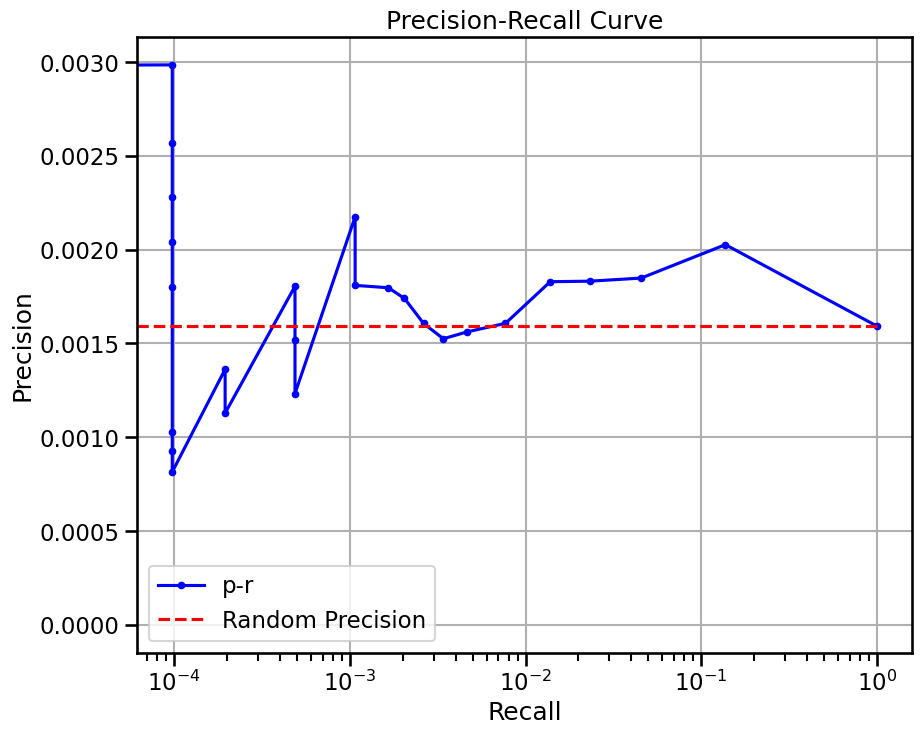

View of AnnData object with n_obs × n_vars = 996 × 2552
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', '

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


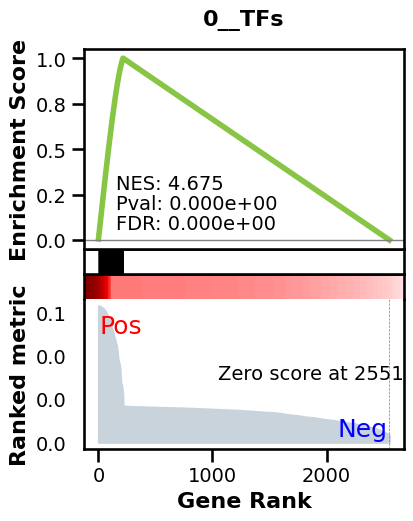

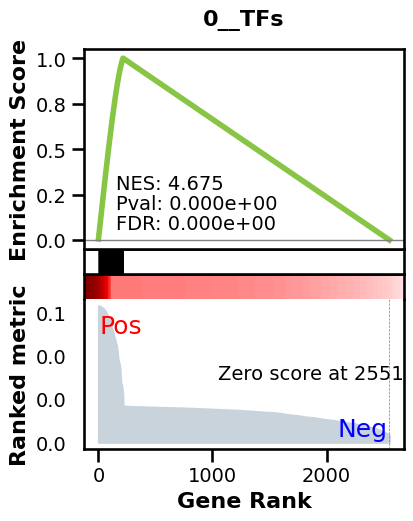

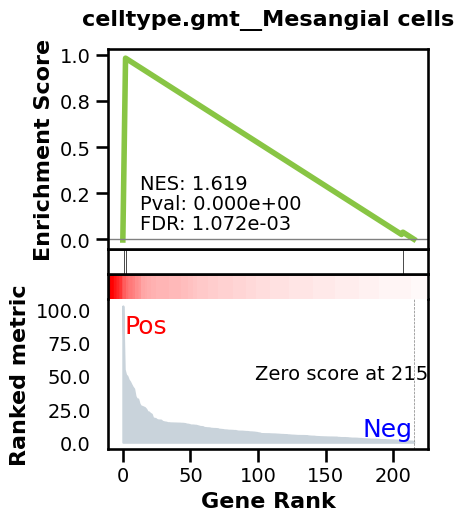

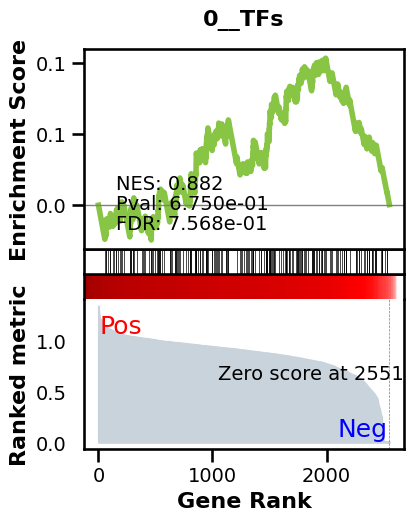

_________________________________________
TF specific enrichment


2024-05-22 15:09:40,667:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:09:40,669:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:09:40,867:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 1721 genes
intersection pct: 0.674373040752351
precision:  0.008112386228729718 
recall:  0.43196592692221475 
random precision: 0.001507033498641947


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 30%|███       | 30/99 [00:00<00:00, 148.21it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 169.24it/s]


Area Under Precision-Recall Curve (AUPRC):  0.008643923396671168
EPR: 13.902486705366233


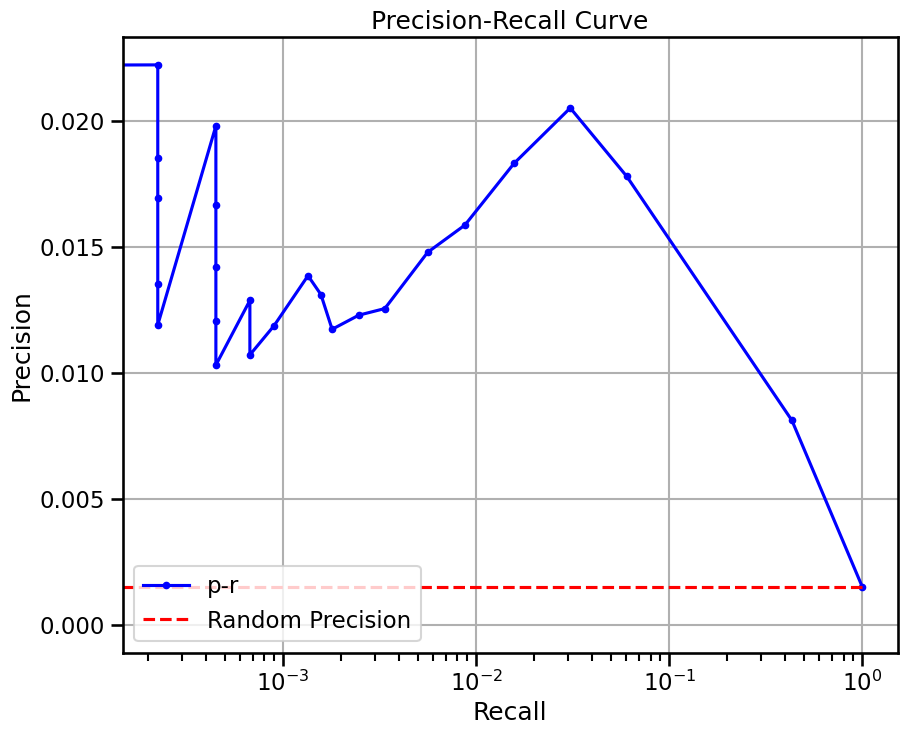

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 34.13 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


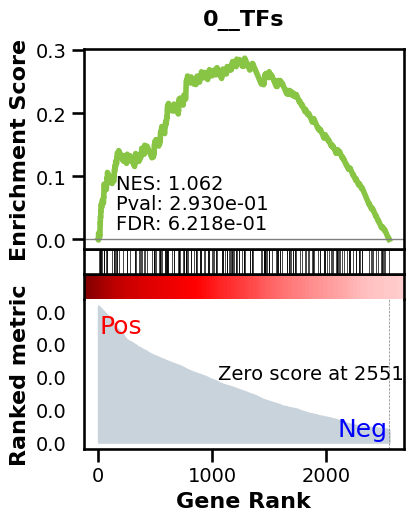

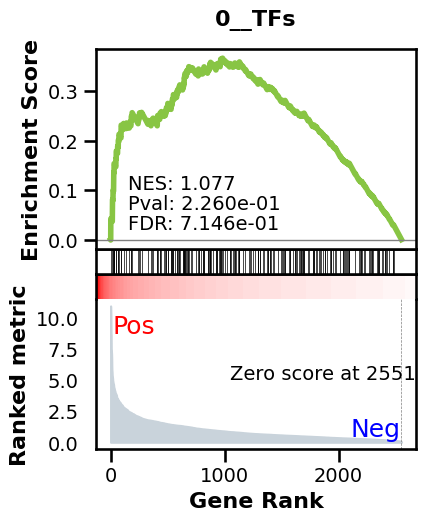

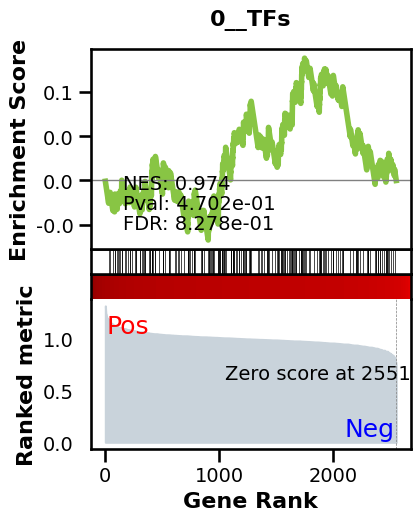

_________________________________________
TF specific enrichment


2024-05-22 15:10:37,015:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:10:37,017:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:10:37,215:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 1721 genes
intersection pct: 0.674373040752351
precision:  0.0019833606480369947 
recall:  0.298139430620937 
random precision: 0.001507033498641947


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: invalid value encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
 34%|███▍      | 34/99 [00:00<00:00, 171.67it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 182.73it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0019330404100234573
EPR: 1.63935356646888


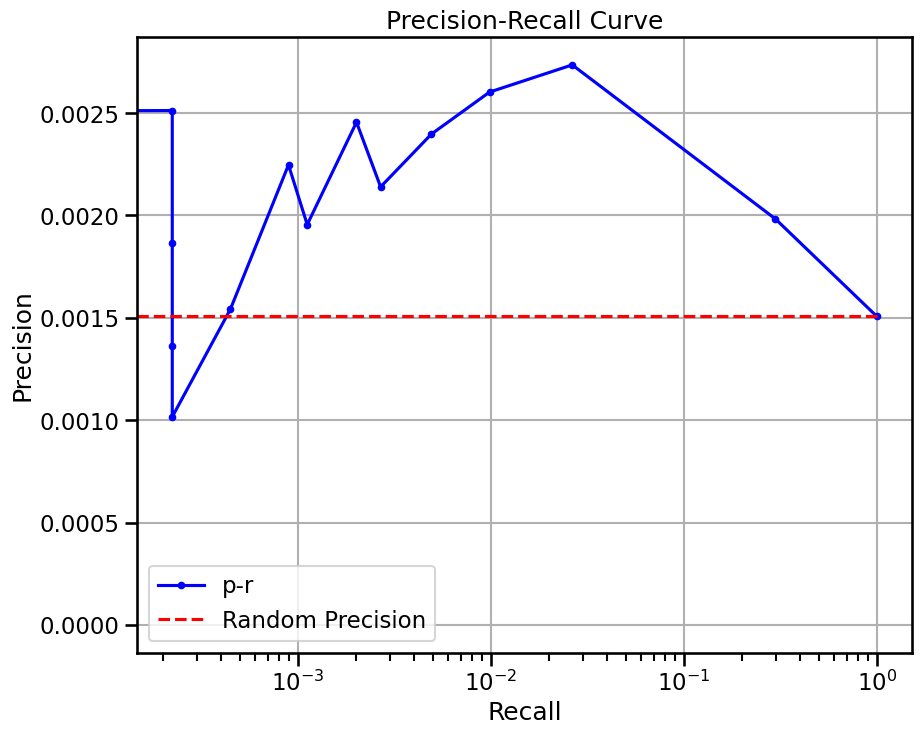

View of AnnData object with n_obs × n_vars = 468 × 3241
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', '

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


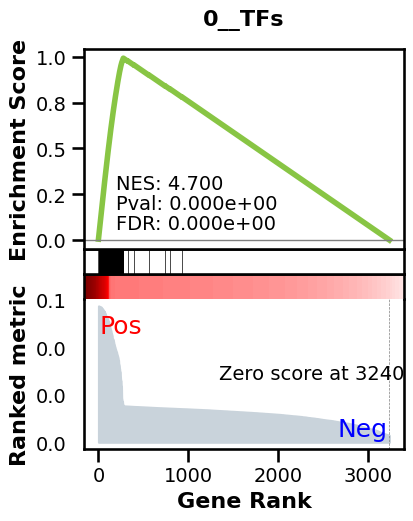

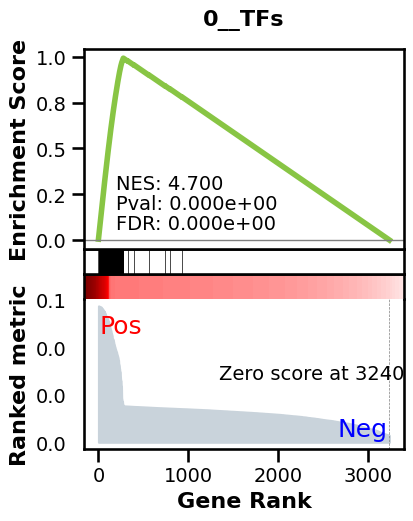

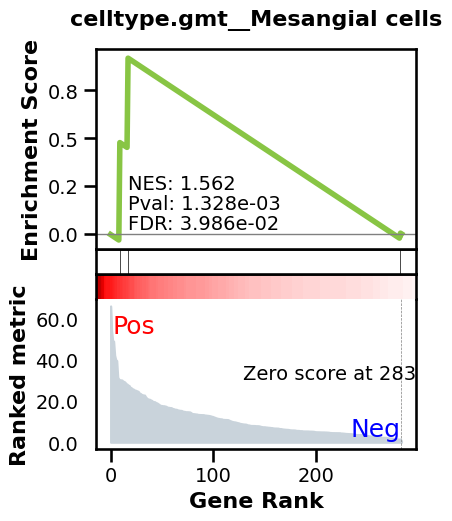

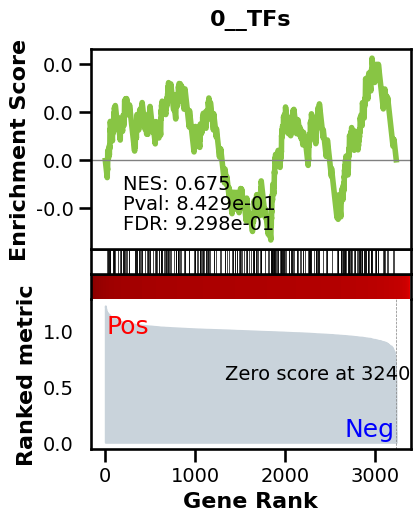

_________________________________________
TF specific enrichment


2024-05-22 15:11:27,193:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:11:27,196:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:11:27,406:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2353 genes
intersection pct: 0.7260104905893243
precision:  0.010697430024905691 
recall:  0.44986127625842254 
random precision: 0.0018235513499917605


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 39%|███▉      | 39/99 [00:00<00:00, 90.82it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 91.16it/s]


Area Under Precision-Recall Curve (AUPRC):  0.009973775034157983
EPR: 7.966377292914338


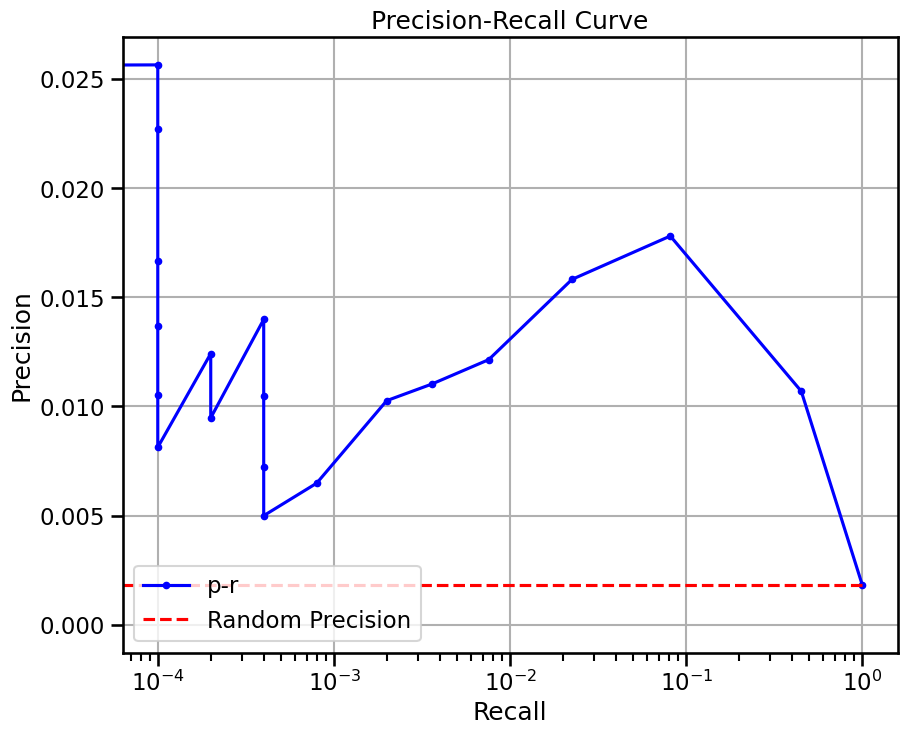

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 35.27 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


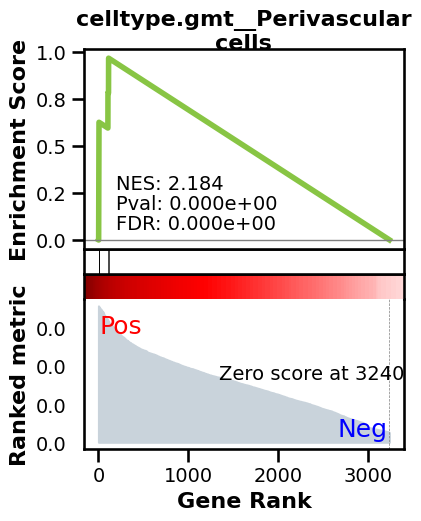

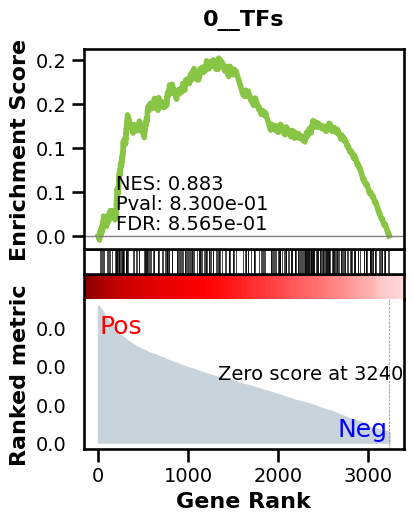

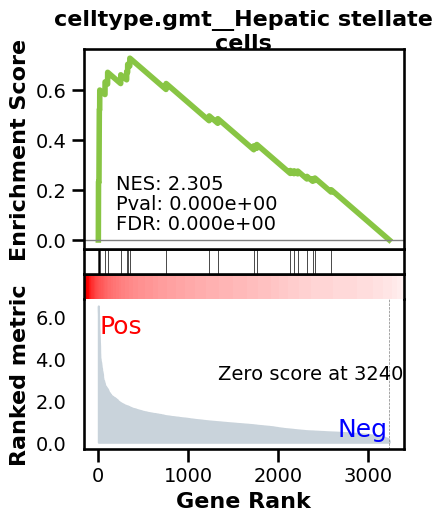

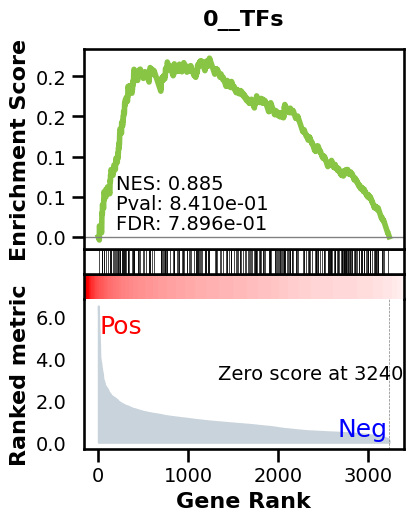

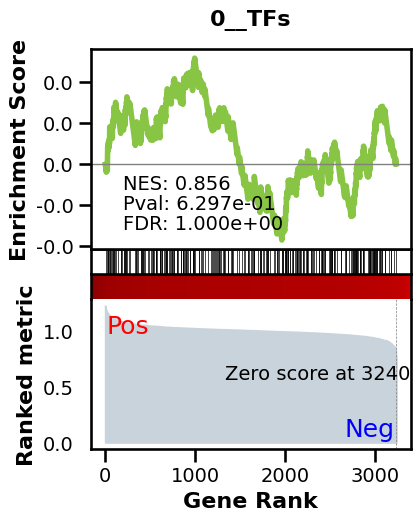

_________________________________________
TF specific enrichment


2024-05-22 15:12:40,237:INFO - Downloading and generating Enrichr library gene sets...
2024-05-22 15:12:40,239:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-22 15:12:40,425:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:109: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros(adj.shape, dtype=np.float)


intersection of 2353 genes
intersection pct: 0.7260104905893243
precision:  0.0026083902644062924 
recall:  0.3738604835513278 
random precision: 0.0018235513499917605


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:677: RuntimeWarning: invalid value encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
 48%|████▊     | 48/99 [00:00<00:00, 93.20it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:683: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:01<00:00, 92.99it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0023241033156039276
EPR: 0.9780081240393453


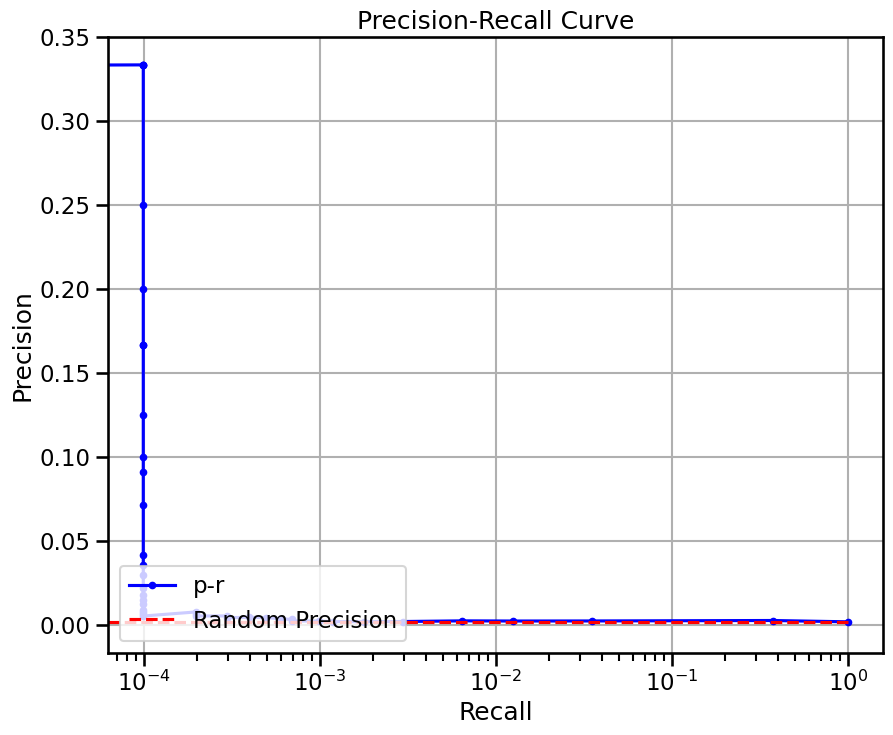

View of AnnData object with n_obs × n_vars = 1024 × 1436
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


base enrichment
Top central genes: []


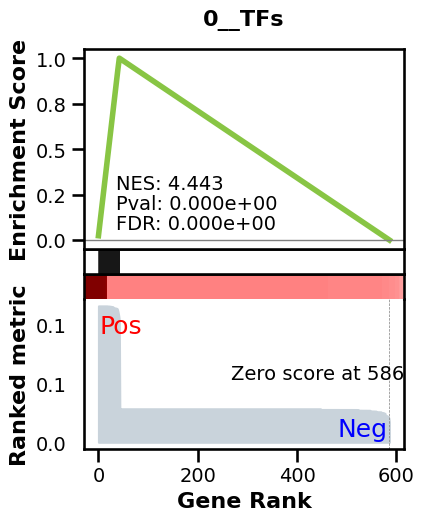

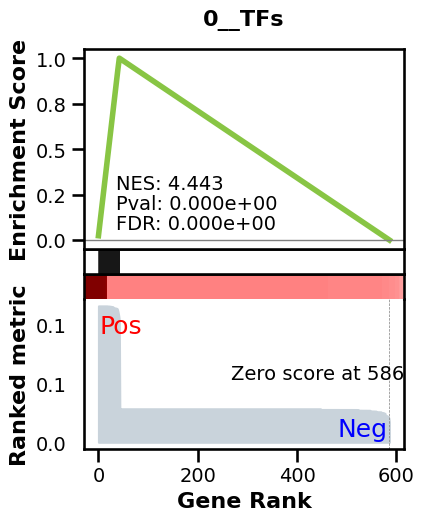

2024-05-22 15:13:10,507 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2024-05-22 15:13:10,510 [ERROR] The first entry of your gene_sets (gmt) look like this : { 0__TFs: [AC008770, AC023509, AC092835, AC138696, ADNP, ADNP2, AEBP1, AEBP2, AHCTF1, AHDC1, AHR, AHRR, AIRE, AKAP8, AKAP8L, AKNA, ALX1, ALX3, ALX4, ANHX, ANKZF1, AR, ARGFX, ARHGAP35, ARID2, ARID3A, ARID3B, ARID3C, ARID5A, ARID5B, ARNT, ARNT2, ARNTL, ARNTL2, ARX, ASCL1, ASCL2, ASCL3, ASCL4, ASCL5, ASH1L, ATF1, ATF2, ATF3, ATF4, ATF5, ATF6, ATF6B, ATF7, ATMIN, ATOH1, ATOH7, ATOH8, BACH1, BACH2, BARHL1, BARHL2, BARX1, BARX2, BATF, BATF2, BATF3, BAZ2A, BAZ2B, BBX, BCL11A, BCL11B, BCL6, BCL6B, BHLHA15, BHLHA9, BHLHE22, BHLHE23, BHLHE40, BHLHE41, BNC1, BNC2, BORCS8-MEF2B, BPTF, BRF2, BSX, C11orf95, CAMTA1, CAMTA2, CARF, CASZ1, CBX2, CC2

LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


In [ ]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype][:1024, adata.var.index.isin(
        model.genes) & adata.var.index.isin(to_use)]
    genie_grn = compute_genie3(
        subadata, nthreads=32, regulators=adata.var[adata.var.isTF].index.tolist())
    genie_grn.var.index = make_index_unique(
        genie_grn.var['symbol'].astype(str))
    metrics['genie3_tf_'+celltype] = BenGRN(genie_grn,
                                            do_auc=True, doplot=True).scprint_benchmark()
    genie_grn = compute_genie3(subadata, nthreads=32)
    genie_grn.var.index = make_index_unique(
        genie_grn.var['symbol'].astype(str))
    metrics['genie3_'+celltype] = BenGRN(genie_grn,
                                         do_auc=True, doplot=True).scprint_benchmark()

## looking at scPRINT inverse network

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 536246649, sparsity: 1.0
base enrichment
too many genes for central computation


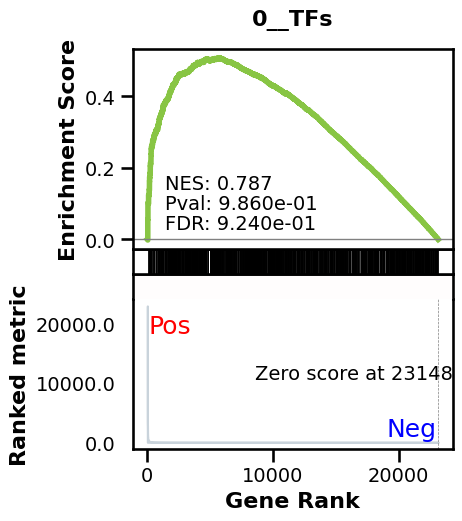

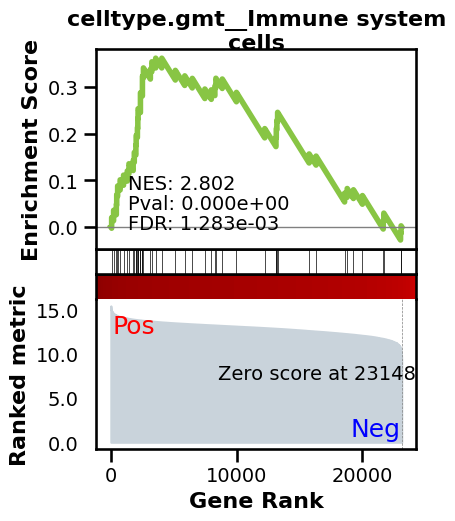

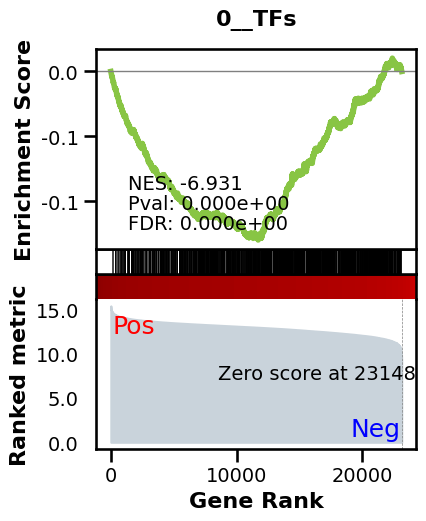

_________________________________________
TF specific enrichment
found some significant results for  64.28571428571429 % TFs

_________________________________________
loading GT,  omnipath
intersection of 12455 genes
intersection pct: 0.5380362002678302
precision:  0.0008896322223674437 
recall:  1.0 
random precision: 0.0008897036558203398


 98%|█████████▊| 97/99 [00:27<00:00,  3.65it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:28<00:00,  3.51it/s]


Area Under Precision-Recall Curve (AUPRC):  0.000908827405793671
EPR: 1.1160067424379267


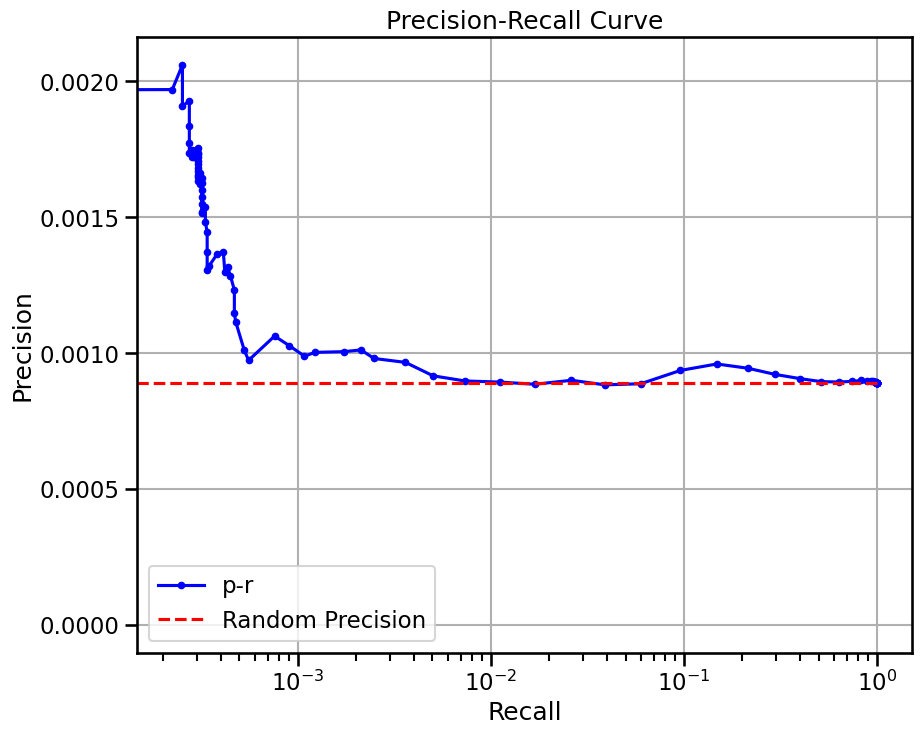

{'enriched_terms_Regulators': ['celltype.gmt__Immune system cells',
  'celltype.gmt__-T cells',
  'celltype.gmt__Effector CD4+ T cells',
  'celltype.gmt__Effector CD8+ T cells',
  'celltype.gmt__Naive CD4+ T cells',
  'celltype.gmt__Memory CD4+ T cells',
  'celltype.gmt__Naive CD8+ T cells',
  'celltype.gmt__Memory CD8+ T cells',
  'celltype.gmt__CD4+ NKT-like cells',
  'celltype.gmt__CD8+ NKT-like cells'],
 'TF_enr': True,
 'significant_enriched_TFtargets': 64.28571428571429,
 'precision': 0.0008896322223674437,
 'recall': 1.0,
 'rand_precision': 0.0008897036558203398,
 'auprc': 0.000908827405793671,
 'epr': 1.1160067424379267}

In [12]:
grn_inferer = GRNfer(model, adata[adata.X.sum(1) > 500],
                         how="random expr",
                         preprocess="softmax",
                         head_agg='max',
                         filtration="none",
                         forward_mode="none",
                         organisms=adata.obs['organism_ontology_term_id'][0],
                         num_genes=NUM_GENES,
                         max_cells=2048,
                         doplot=False,
                         batch_size=32,
                         )
grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type=CELLTYPES[0])
grn.varp['GRN'] = grn.varp['GRN'].T
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
BenGRN(grn).scprint_benchmark()

base enrichment
too many genes for central computation


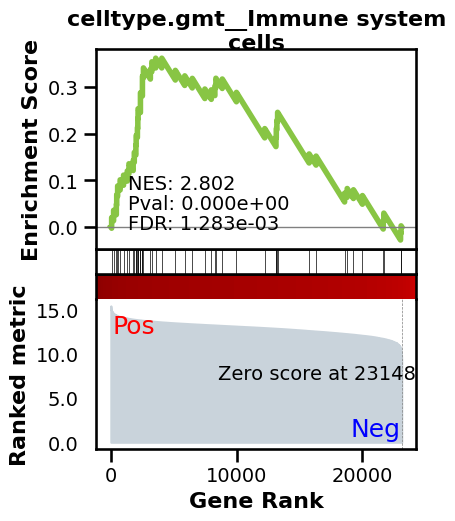

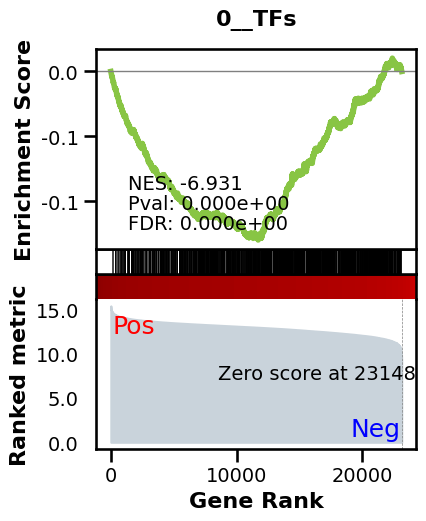

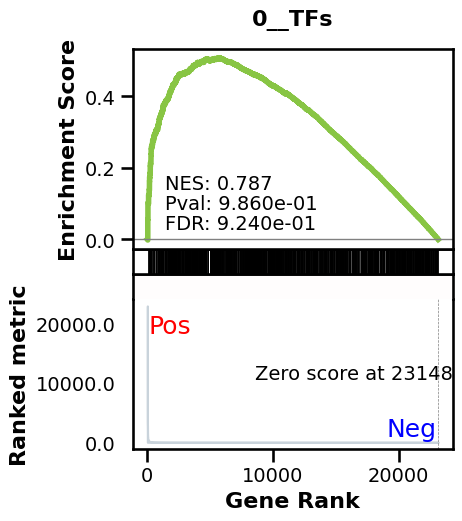

_________________________________________
TF specific enrichment
found some significant results for  4.464285714285714 % TFs

_________________________________________
loading GT,  omnipath
intersection of 12455 genes
intersection pct: 0.5380362002678302
precision:  0.0008896322223674437 
recall:  1.0 
random precision: 0.0008897036558203398


 98%|█████████▊| 97/99 [00:24<00:00,  3.79it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:25<00:00,  3.90it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0009504892616186736
EPR: 1.7697436555222488


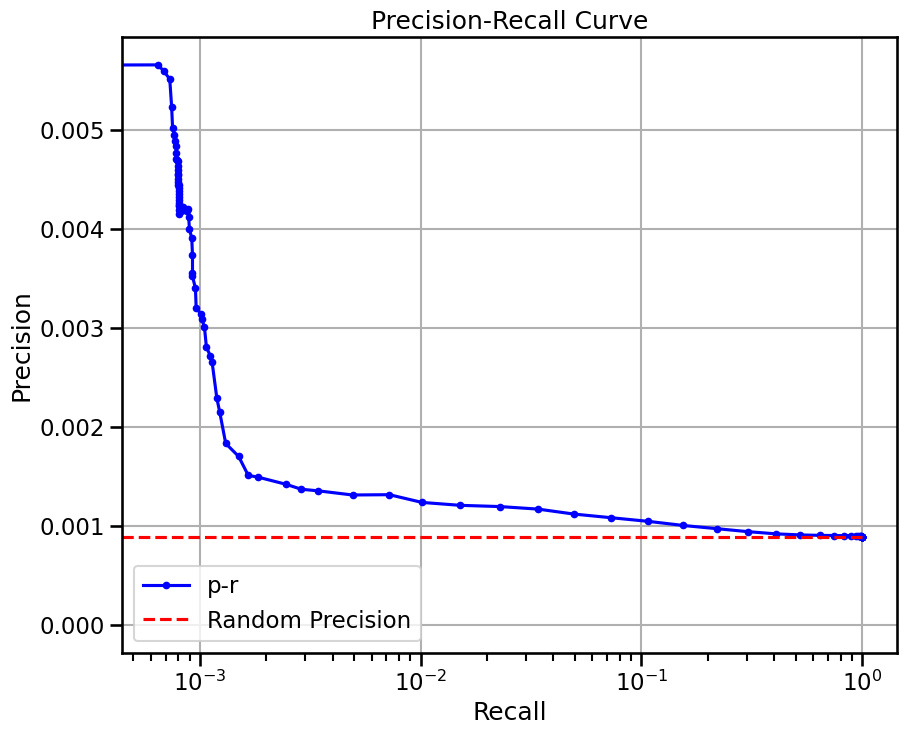

{'enriched_terms_Targets': ['celltype.gmt__Immune system cells',
  'celltype.gmt__-T cells',
  'celltype.gmt__Effector CD4+ T cells',
  'celltype.gmt__Effector CD8+ T cells',
  'celltype.gmt__Naive CD4+ T cells',
  'celltype.gmt__Memory CD4+ T cells',
  'celltype.gmt__Naive CD8+ T cells',
  'celltype.gmt__Memory CD8+ T cells',
  'celltype.gmt__CD4+ NKT-like cells',
  'celltype.gmt__CD8+ NKT-like cells'],
 'TF_enr': True,
 'significant_enriched_TFtargets': 4.464285714285714,
 'precision': 0.0008896322223674437,
 'recall': 1.0,
 'rand_precision': 0.0008897036558203398,
 'auprc': 0.0009504892616186736,
 'epr': 1.7697436555222488}

In [15]:
grn.varp['GRN'] = grn.varp['GRN'].T
BenGRN(grn).scprint_benchmark()

In [6]:
grn_inferer = GRNfer(model, adata[adata.X.sum(1) > 500],
                         how="most var across",
                         preprocess="softmax",
                         head_agg='none',
                         filtration="none",
                         forward_mode="none",
                         organisms=adata.obs['organism_ontology_term_id'][0],
                         num_genes=2000,
                         max_cells=2048,
                         doplot=False,
                         batch_size=32,
                         )
grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type=celltype)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

true elem 3113 ...
doing classification....
metrics {'used_heads': 20, 'precision': 0.0014497414457597614, 'random_precision': 0.0014104094132499582, 'recall': 0.993006993006993, 'predicted_true': 195897.0, 'number_of_true': 286.0, 'epr': 2.4894675284702985}


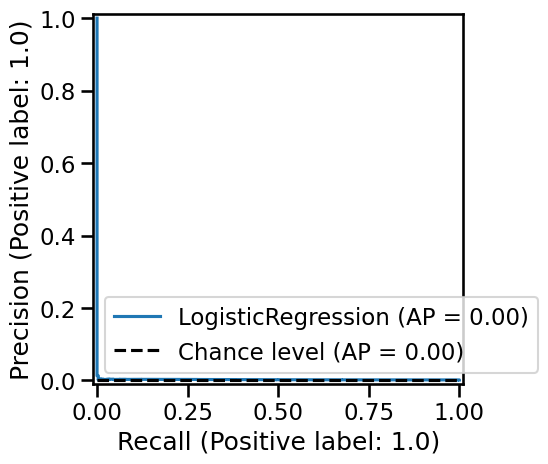

base enrichment
Top central genes: []


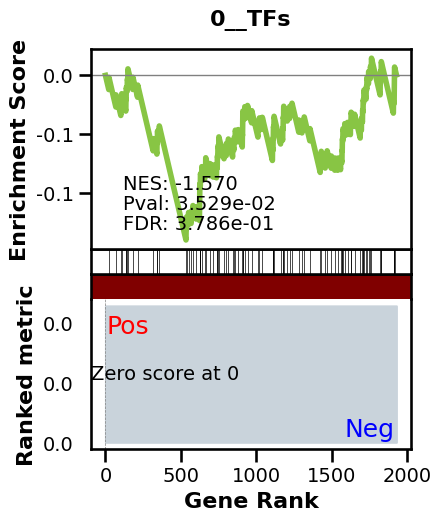

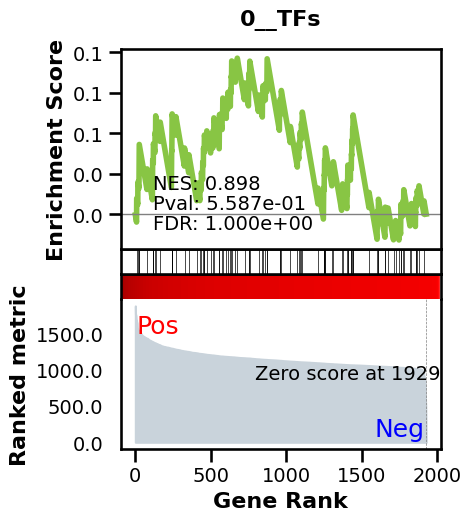

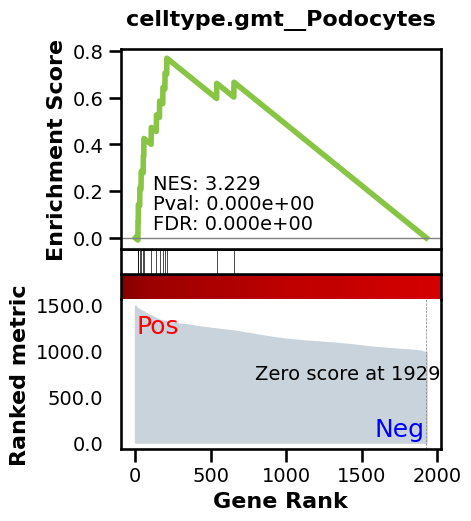

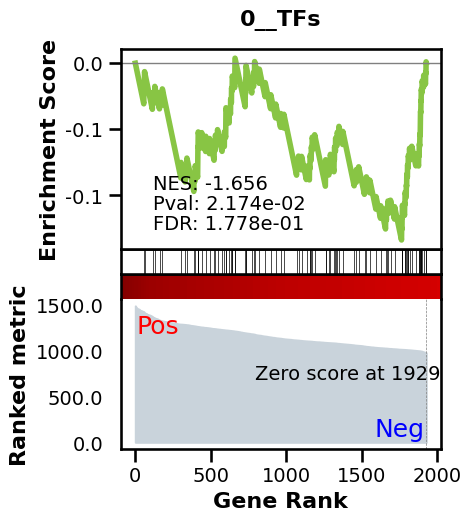

_________________________________________
TF specific enrichment
found some significant results for  40.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1424 genes
intersection pct: 0.7378238341968912
precision:  0.0015351794281025122 
recall:  1.0 
random precision: 0.0015362582611510734


 81%|████████  | 80/99 [00:00<00:00, 275.48it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 268.26it/s]


Area Under Precision-Recall Curve (AUPRC):  0.00214417393833262
EPR: 2.098055908179468


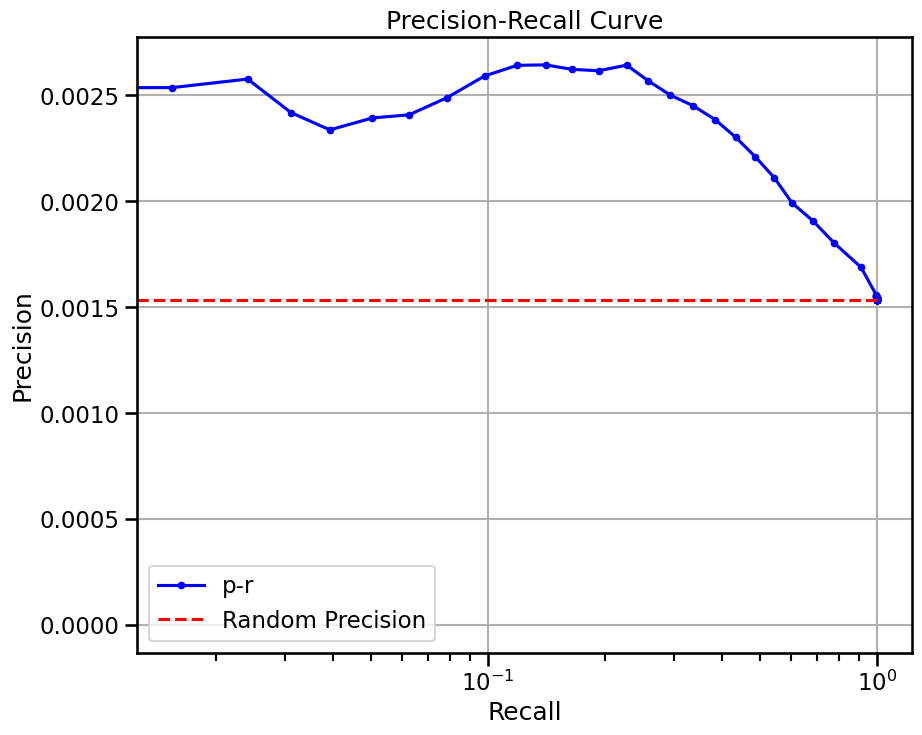

base enrichment
Top central genes: []


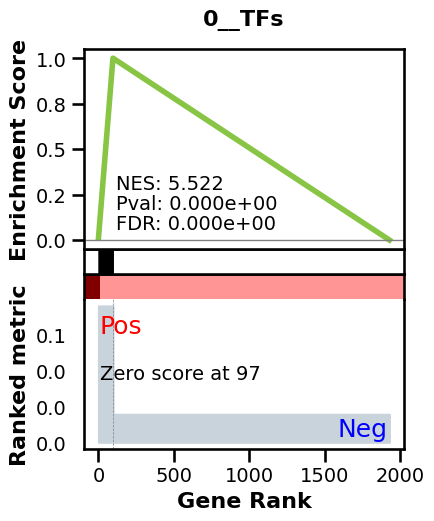

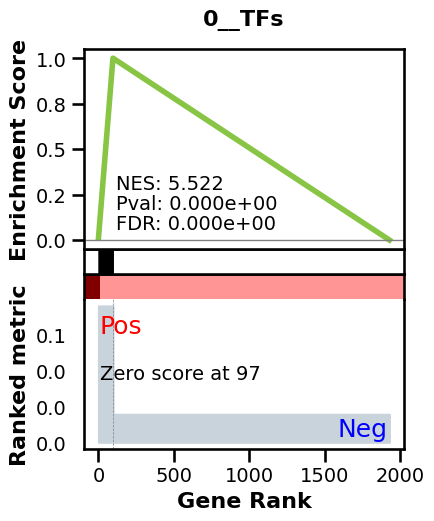

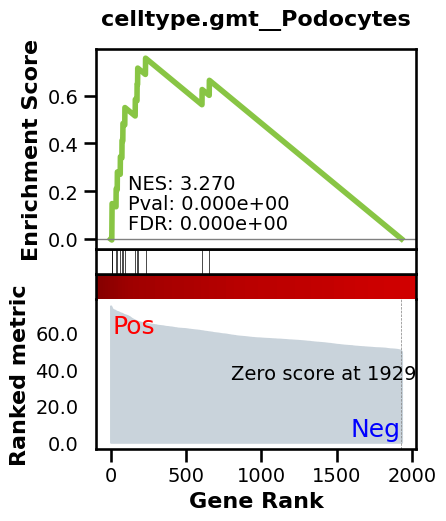

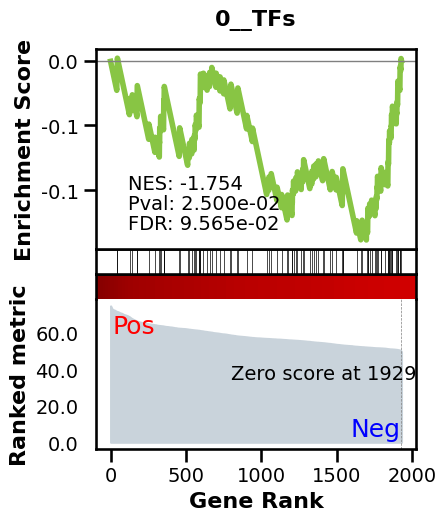

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1424 genes
intersection pct: 0.7378238341968912
precision:  0.00813170326864147 
recall:  0.32733697398008355 
random precision: 0.0015362582611510734


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:714: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 48%|████▊     | 48/99 [00:00<00:00, 248.82it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 267.35it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0074968642632914995
EPR: 12.554415315505958


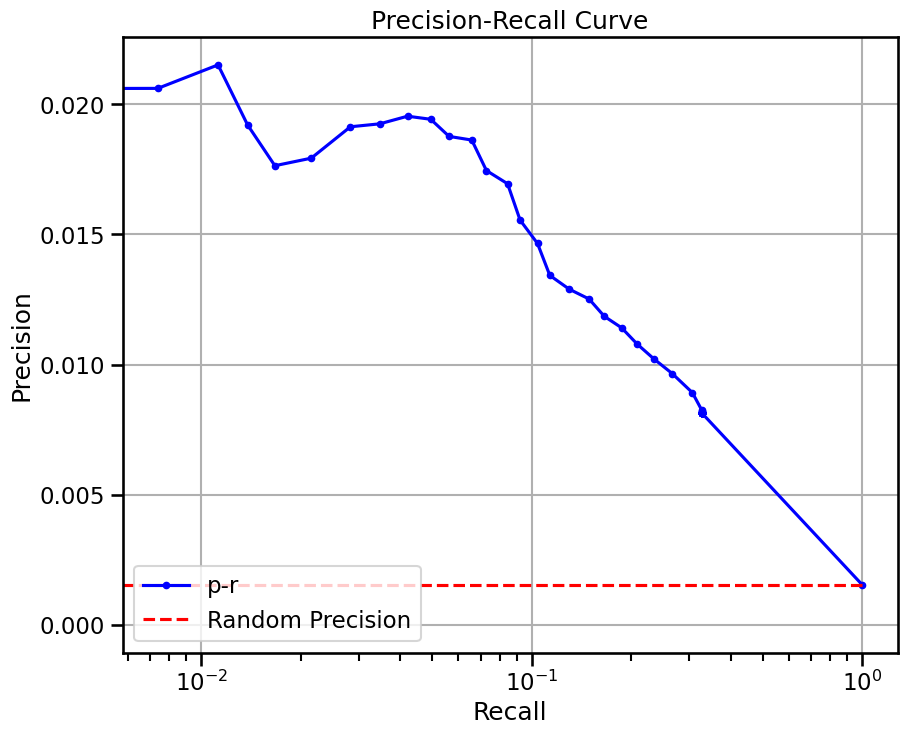

{'enriched_terms_Central': ['0__TFs', 'celltype.gmt__Embryonic stem cells'],
 'TF_enr': True,
 'enriched_terms_Regulators': ['celltype.gmt__Podocytes',
  'celltype.gmt__Hepatic stellate cells',
  'celltype.gmt__Langerhans cells',
  'celltype.gmt__Smooth muscle cells',
  'celltype.gmt__Myofibroblasts',
  'celltype.gmt__Myoepithelial cells',
  'celltype.gmt__Mesangial cells',
  'celltype.gmt__Pulmonary alveolar type I cells',
  'celltype.gmt__Hepatocytes',
  'celltype.gmt__Lymphatic Endothelial cells',
  'celltype.gmt__Acinar cells',
  'celltype.gmt__Myocytes',
  'celltype.gmt__Plasmacytoid Dendritic cells',
  'celltype.gmt__Melanocytes',
  'celltype.gmt__Enterocytes',
  'celltype.gmt__Endothelial',
  'celltype.gmt__Pancreatic stellate cells',
  'celltype.gmt__Alveolar macrophages',
  'celltype.gmt__Immune system cells'],
 'significant_enriched_TFtargets': 0.0,
 'precision': 0.00813170326864147,
 'recall': 0.32733697398008355,
 'rand_precision': 0.0015362582611510734,
 'auprc': 0.0074968

In [9]:
grn.varp['GRN'] = np.transpose(grn.varp['GRN'], (1,0,2))
grn, m, clf_omni = train_classifier(grn, C=0.04, train_size=0.9, class_weight={
                                    1: 1_000, 0: 1}, shuffle=True, max_iter=200)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
BenGRN(grn).scprint_benchmark()
grn.varp['GRN'][~grn.var.index.isin(grnutils.TF),:] = 0
BenGRN(grn).scprint_benchmark()

0,0023 0,0082, 16h
0,0021 0,0091, 7h

In [14]:
clf_omni.coef_

array([[  4.85484165,   0.        ,   0.        ,   0.        ,
          4.16136553,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  87.36583608,   0.        ,
         40.42494803,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
        101.37991387,   0.        ,   0.        ,   0.        ,
          0.        ,  -2.76196327, 111.91070039,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

true elem 3113 ...
doing classification....
metrics {'used_heads': 7, 'precision': 0.0012173996343809623, 'random_precision': 0.0012082202373437697, 'recall': 0.9959183673469387, 'predicted_true': 1002136.0, 'number_of_true': 1225.0, 'epr': 0.0}


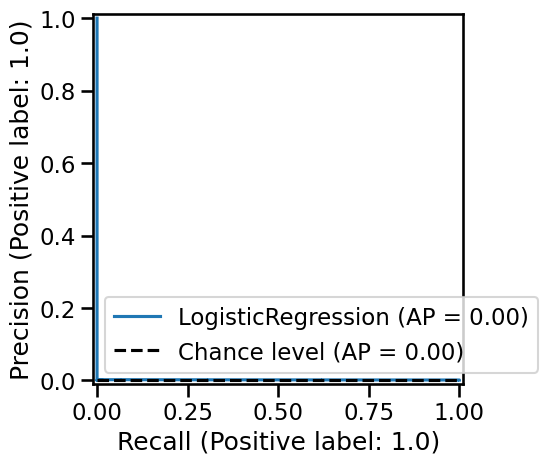

base enrichment
Top central genes: []


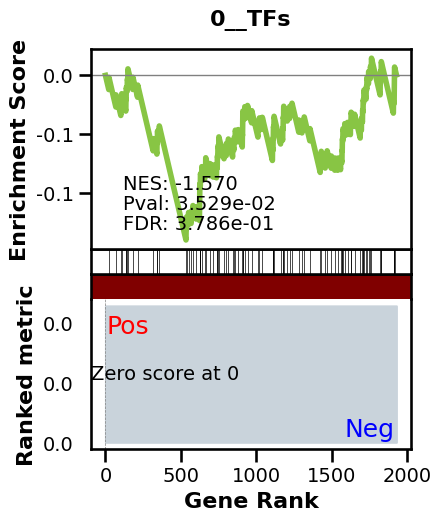

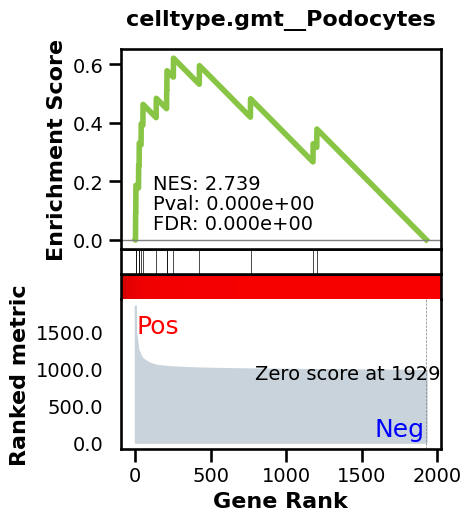

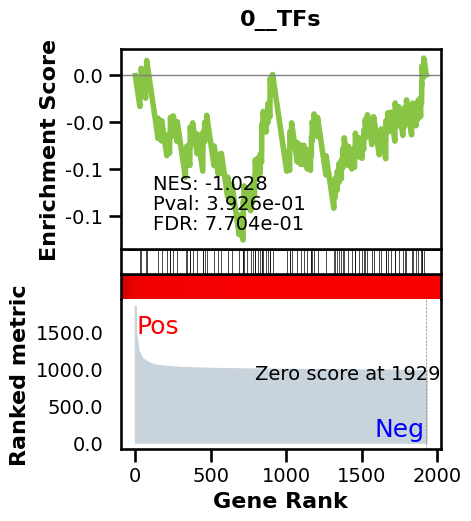

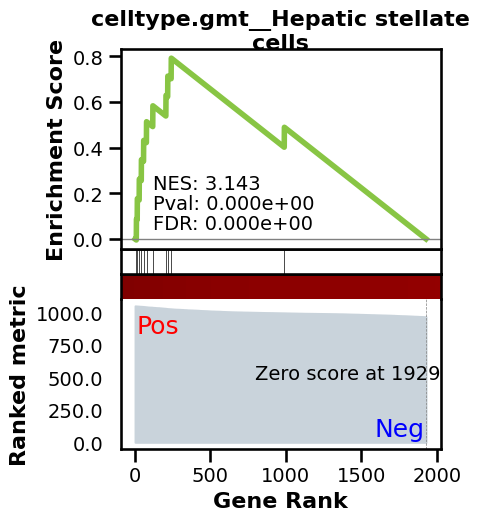

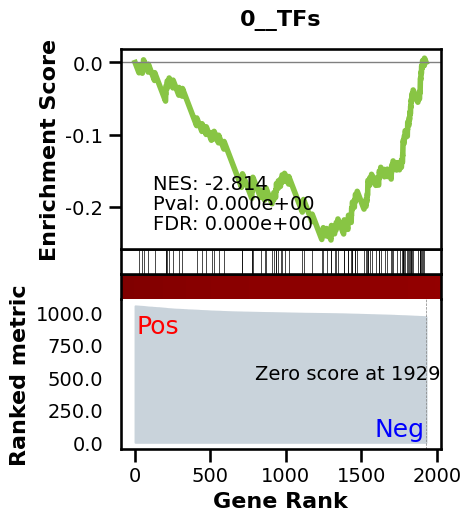

_________________________________________
TF specific enrichment
found some significant results for  20.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1424 genes
intersection pct: 0.7378238341968912
precision:  0.0015351794281025122 
recall:  1.0 
random precision: 0.0015362582611510734


 80%|███████▉  | 79/99 [00:00<00:00, 270.81it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 263.63it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0021519607381099257
EPR: 0.8359838073735855


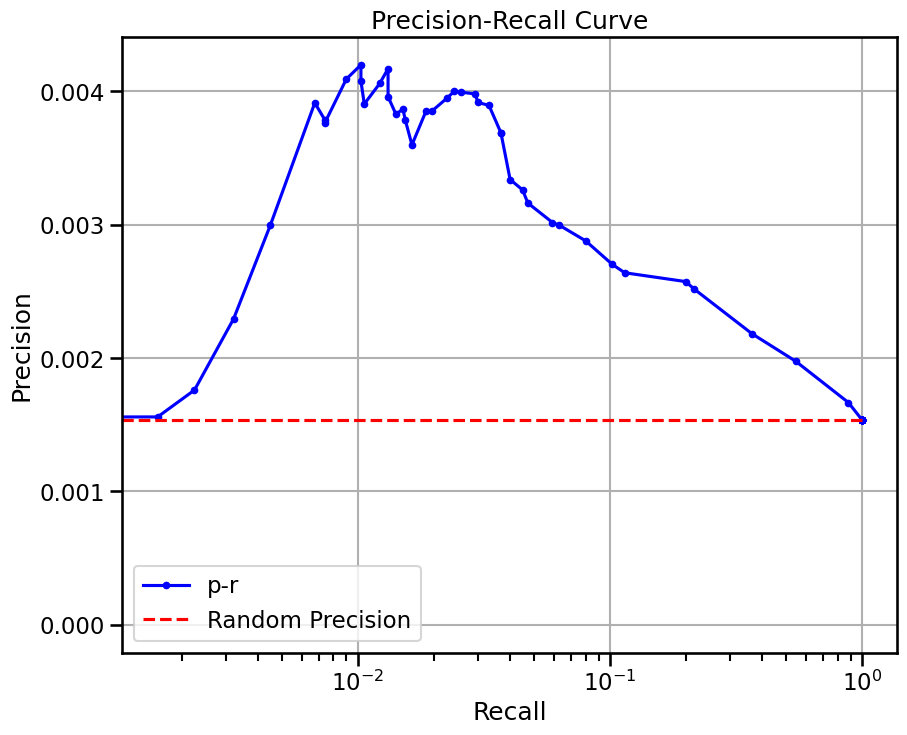

base enrichment
Top central genes: []


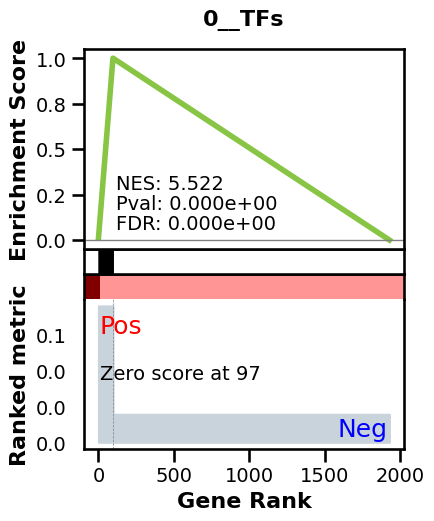

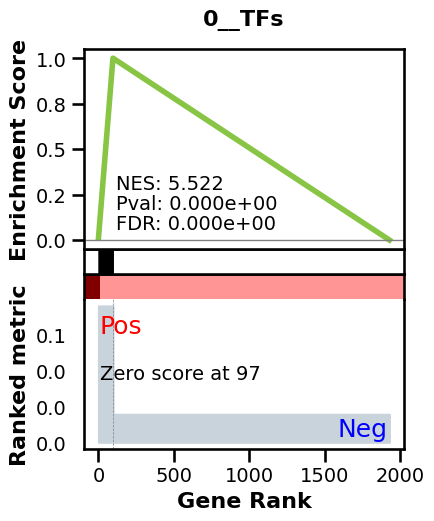

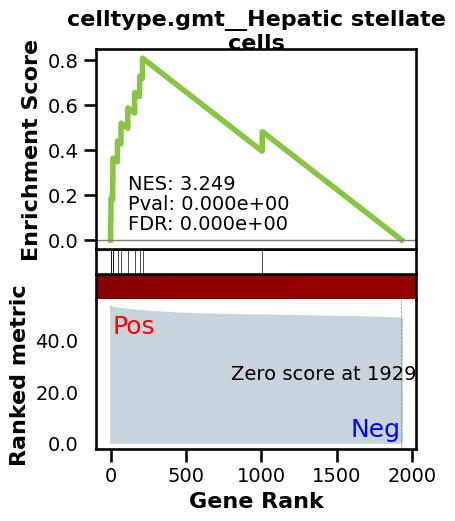

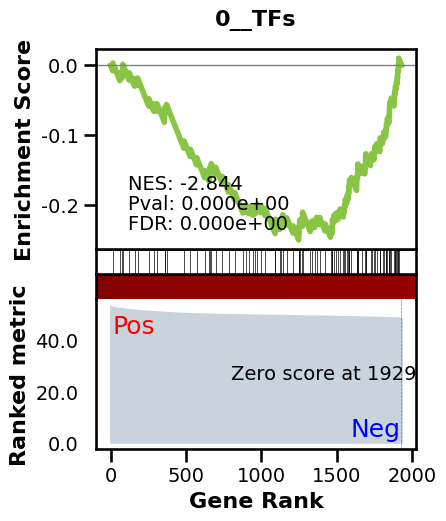

_________________________________________
TF specific enrichment
found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1424 genes
intersection pct: 0.7378238341968912
precision:  0.00813170326864147 
recall:  0.32733697398008355 
random precision: 0.0015362582611510734


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:714: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 41%|████▏     | 41/99 [00:00<00:00, 212.49it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:720: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 249.70it/s]


Area Under Precision-Recall Curve (AUPRC):  0.009161094512500129
EPR: 21.070945104719595


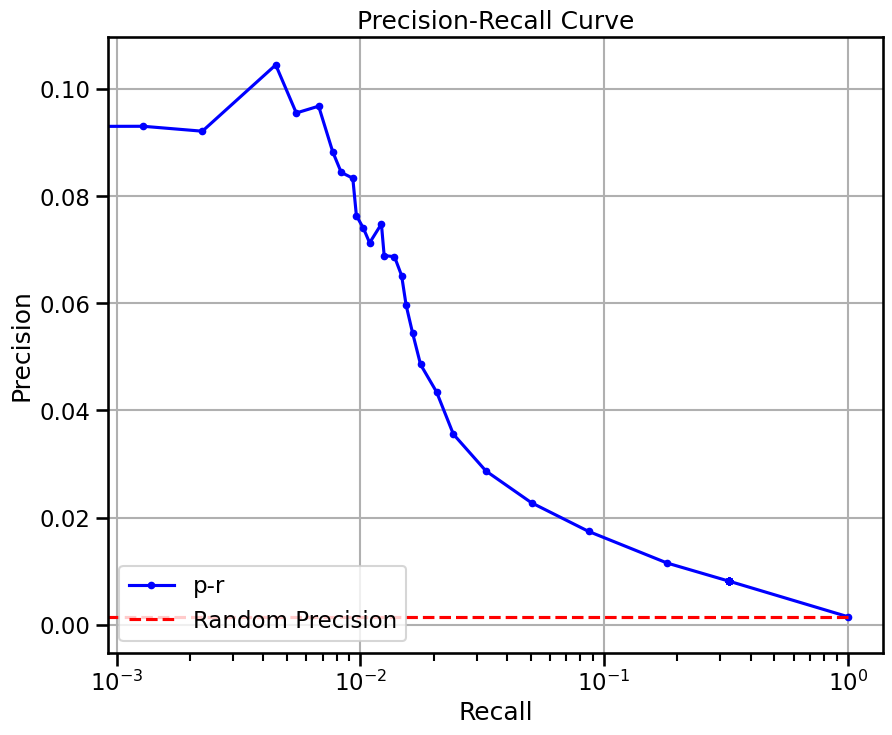

{'enriched_terms_Central': ['0__TFs', 'celltype.gmt__Embryonic stem cells'],
 'TF_enr': True,
 'enriched_terms_Regulators': ['celltype.gmt__Hepatic stellate cells',
  'celltype.gmt__Podocytes',
  'celltype.gmt__Smooth muscle cells',
  'celltype.gmt__Langerhans cells',
  'celltype.gmt__Pulmonary alveolar type I cells',
  'celltype.gmt__Immune system cells',
  'celltype.gmt__Myofibroblasts',
  'celltype.gmt__Hepatocytes',
  'celltype.gmt__Myoepithelial cells',
  'celltype.gmt__Acinar cells',
  'celltype.gmt__Melanocytes',
  'celltype.gmt__Alveolar macrophages',
  'celltype.gmt__Beta cells',
  'celltype.gmt__Adipose progenitor cells',
  'celltype.gmt__Endothelial',
  'celltype.gmt__Plasmacytoid Dendritic cells',
  'celltype.gmt__Kupffer cells',
  'celltype.gmt__Pancreatic stellate cells',
  'celltype.gmt__Lymphatic Endothelial cells',
  'celltype.gmt__Progenitor cells',
  'celltype.gmt__Pericytes',
  'celltype.gmt__ISG expressing immune cells',
  'celltype.gmt__Non-classical monocytes',
 

In [13]:
grn.varp['GRN'] = np.transpose(grn.varp['all'], (1,0,2))
grn, m, clf_omni = train_classifier(grn, C=0.01, train_size=0.5, class_weight={
                                    1: 1_000, 0: 1}, shuffle=False, max_iter=200)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
BenGRN(grn).scprint_benchmark()
grn.varp['GRN'][~grn.var.index.isin(grnutils.TF),:] = 0
BenGRN(grn).scprint_benchmark()

## looking at classifier reusability

# looking at 